# Exploratory Data Analysis

This notebook documents characteristics of the raw data used in the project and some aspects of preprocessing. The main preprocessing is done in the following notebooks in `experiments/v/`: 
- `0_Get_Features.ipynb`,
- `0_Get_Targets.ipynb`,
- `0_Merge_Data.ipynb`.

Results of that preprocessing are stored in `data_df.csv`. Here, we will load that data, as well as raw data, and inspect a few alternative methods for computing the target variable (volatility) and order book features. This is done in order to understand how preprocessing choices made in `experiments/v/` affect the data we are using.

No preprocessing is done here, and no output is generated. Additional preprocessing made after the main one from `experiments/v/` includes the computation of trade volume and it is performed in `experiments/miro/2.0-mz-preprocessing.ipynb`.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

sns.set(style="whitegrid")

import os
import sys
from pathlib import Path
from zipfile import ZipFile

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths

In [3]:
data_path = PROJ_ROOT / "data"
raw_data_path = PROJ_ROOT / "data" / "raw"

# Data Availability

There are two groups of data: trade data and order book data. We will treat them in the EDA separately. 

Trade data is available for the period: **01**.06.2018 - 30.09.2018 and it is stored as `bitstamp_trx_DD_MM_2018.zip` \
Order book data is available for the period: **05**.06.2018 - 30.09.2018 and it is stored as `bitstamp_ob_DD_MM_2018.zip`

Trade data files are ~1Mb per file (per day). \
OB data ~150Mb per zip file, and around 650Mb unzipped. 

# Order book data - single bistamp file

## Load and format

### Time loading and unpacking

In [4]:
ob_sample = pd.read_csv(raw_data_path / "bitstamp_ob_05_06_2018.zip")

Pandas takes around 10s per file to unzip and load into a dataframe. We expect around 2.5 hours only for loading the data. We will use polars for this task.

In [5]:
with ZipFile(raw_data_path / "bitstamp_ob_05_06_2018.zip", "r") as zip_ref:
    zip_ref.extractall(raw_data_path)

In [6]:
pl.read_csv(
    ZipFile(raw_data_path / "bitstamp_ob_05_06_2018.zip").read(
        "bitstamp_ob_05_06_2018.csv"
    )
)

shape: (24_475_306, 4)
┌────────────┬──────┬──────────┬──────────┐
│ time       ┆ type ┆ price    ┆ amount   │
│ ---        ┆ ---  ┆ ---      ┆ ---      │
│ i64        ┆ str  ┆ f64      ┆ f64      │
╞════════════╪══════╪══════════╪══════════╡
│ 1528149602 ┆ b    ┆ 7537.0   ┆ 3.227621 │
│ 1528149602 ┆ b    ┆ 7535.15  ┆ 0.1389   │
│ 1528149602 ┆ b    ┆ 7532.5   ┆ 0.4056   │
│ 1528149602 ┆ b    ┆ 7531.73  ┆ 0.2      │
│ 1528149602 ┆ b    ┆ 7530.02  ┆ 0.3      │
│ …          ┆ …    ┆ …        ┆ …        │
│ 1528235974 ┆ a    ┆ 15084.0  ┆ 0.076    │
│ 1528235974 ┆ a    ┆ 15087.0  ┆ 0.02     │
│ 1528235974 ┆ a    ┆ 15088.0  ┆ 0.0744   │
│ 1528235974 ┆ a    ┆ 15091.44 ┆ 0.008    │
│ 1528235974 ┆ a    ┆ 15095.0  ┆ 1.21     │
└────────────┴──────┴──────────┴──────────┘

In [7]:
pl.read_csv(raw_data_path / "bitstamp_ob_05_06_2018.csv")

shape: (24_475_306, 4)
┌────────────┬──────┬──────────┬──────────┐
│ time       ┆ type ┆ price    ┆ amount   │
│ ---        ┆ ---  ┆ ---      ┆ ---      │
│ i64        ┆ str  ┆ f64      ┆ f64      │
╞════════════╪══════╪══════════╪══════════╡
│ 1528149602 ┆ b    ┆ 7537.0   ┆ 3.227621 │
│ 1528149602 ┆ b    ┆ 7535.15  ┆ 0.1389   │
│ 1528149602 ┆ b    ┆ 7532.5   ┆ 0.4056   │
│ 1528149602 ┆ b    ┆ 7531.73  ┆ 0.2      │
│ 1528149602 ┆ b    ┆ 7530.02  ┆ 0.3      │
│ …          ┆ …    ┆ …        ┆ …        │
│ 1528235974 ┆ a    ┆ 15084.0  ┆ 0.076    │
│ 1528235974 ┆ a    ┆ 15087.0  ┆ 0.02     │
│ 1528235974 ┆ a    ┆ 15088.0  ┆ 0.0744   │
│ 1528235974 ┆ a    ┆ 15091.44 ┆ 0.008    │
│ 1528235974 ┆ a    ┆ 15095.0  ┆ 1.21     │
└────────────┴──────┴──────────┴──────────┘

Polars takes 4.5s per file to unzip and load into a dataframe. Unzip to disk takes ~2.5s, reading csv ~1s. 

Given the limited disk space, we will 

## Compute features

> 05/06 is an example of a day without extremely large orders

> 21/06 is an example of a day when a few very big bid orders which are totally changing the correlation matrix and

> 15/08 is an example of a day with strong drift in the order book features

Conclusions at the end of this subsection are given by making observations on the example days. 

In [8]:
ob_sample = pl.read_csv(
    ZipFile(raw_data_path / "bitstamp_ob_05_06_2018.zip").read(
        "bitstamp_ob_05_06_2018.csv"
    )
)

In [9]:
ob_sample = (
    ob_sample.with_columns((pl.col("type") == "b").alias("is_bid"))
    .drop("type")
    .rename({"amount ": "amount"})
)

In [10]:
ob_sample

shape: (24_475_306, 4)
┌────────────┬──────────┬──────────┬────────┐
│ time       ┆ price    ┆ amount   ┆ is_bid │
│ ---        ┆ ---      ┆ ---      ┆ ---    │
│ i64        ┆ f64      ┆ f64      ┆ bool   │
╞════════════╪══════════╪══════════╪════════╡
│ 1528149602 ┆ 7537.0   ┆ 3.227621 ┆ true   │
│ 1528149602 ┆ 7535.15  ┆ 0.1389   ┆ true   │
│ 1528149602 ┆ 7532.5   ┆ 0.4056   ┆ true   │
│ 1528149602 ┆ 7531.73  ┆ 0.2      ┆ true   │
│ 1528149602 ┆ 7530.02  ┆ 0.3      ┆ true   │
│ …          ┆ …        ┆ …        ┆ …      │
│ 1528235974 ┆ 15084.0  ┆ 0.076    ┆ false  │
│ 1528235974 ┆ 15087.0  ┆ 0.02     ┆ false  │
│ 1528235974 ┆ 15088.0  ┆ 0.0744   ┆ false  │
│ 1528235974 ┆ 15091.44 ┆ 0.008    ┆ false  │
│ 1528235974 ┆ 15095.0  ┆ 1.21     ┆ false  │
└────────────┴──────────┴──────────┴────────┘

OB data consist of individual orders with associated `time`. Time is ticking with approximately 30 seconds frequency. We will form order book features by computing statistics by aggregating orders of the same `time`.

In [11]:
ob_desc = ob_sample.with_columns(
    pl.when(pl.col("is_bid")).then(pl.col("price")).otherwise(None).alias("bid_price"),
    pl.when(~pl.col("is_bid")).then(pl.col("price")).otherwise(None).alias("ask_price"),
)

ob_desc.describe()

shape: (9, 7)
┌────────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬──────────────┐
│ statistic  ┆ time         ┆ price       ┆ amount      ┆ is_bid      ┆ bid_price   ┆ ask_price    │
│ ---        ┆ ---          ┆ ---         ┆ ---         ┆ ---         ┆ ---         ┆ ---          │
│ str        ┆ f64          ┆ f64         ┆ f64         ┆ f64         ┆ f64         ┆ f64          │
╞════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪══════════════╡
│ count      ┆ 2.4475306e7  ┆ 2.4475306e7 ┆ 2.4475306e7 ┆ 2.4475306e7 ┆ 1.0075306e7 ┆ 1.44e7       │
│ null_count ┆ 0.0          ┆ 0.0         ┆ 0.0         ┆ 0.0         ┆ 1.44e7      ┆ 1.0075306e7  │
│ mean       ┆ 1.5282e9     ┆ 7956.449587 ┆ 69.308443   ┆ 0.411652    ┆ 4567.823124 ┆ 10327.383512 │
│ std        ┆ 24982.877102 ┆ 3490.528417 ┆ 3268.343835 ┆ null        ┆ 2323.384671 ┆ 1809.975121  │
│ min        ┆ 1.5281e9     ┆ 0.01        ┆ 3.0000e-8   ┆ 0.0         ┆ 0.01        ┆ 7361.53      │
│ 25%        ┆ 1.5282e9     ┆ 6000.0      ┆ 0.002937    ┆ null        ┆ 2921.0      ┆ 9189.73      │
│ 50%        ┆ 1.5282e9     ┆ 8580.45     ┆ 0.05        ┆ null        ┆ 5261.0      ┆ 9822.95      │
│ 75%        ┆ 1.5282e9     ┆ 9934.75     ┆ 0.3803      ┆ null        ┆ 6530.0      ┆ 11489.0      │
│ max        ┆ 1.5282e9     ┆ 15327.0     ┆ 268634.1292 ┆ 1.0         ┆ 7665.0      ┆ 15327.0      │
└────────────┴──────────────┴─────────────┴─────────────┴─────────────┴─────────────┴──────────────┘

### Inspect Single Timestamp

In [12]:
ob_sample

shape: (24_475_306, 4)
┌────────────┬──────────┬──────────┬────────┐
│ time       ┆ price    ┆ amount   ┆ is_bid │
│ ---        ┆ ---      ┆ ---      ┆ ---    │
│ i64        ┆ f64      ┆ f64      ┆ bool   │
╞════════════╪══════════╪══════════╪════════╡
│ 1528149602 ┆ 7537.0   ┆ 3.227621 ┆ true   │
│ 1528149602 ┆ 7535.15  ┆ 0.1389   ┆ true   │
│ 1528149602 ┆ 7532.5   ┆ 0.4056   ┆ true   │
│ 1528149602 ┆ 7531.73  ┆ 0.2      ┆ true   │
│ 1528149602 ┆ 7530.02  ┆ 0.3      ┆ true   │
│ …          ┆ …        ┆ …        ┆ …      │
│ 1528235974 ┆ 15084.0  ┆ 0.076    ┆ false  │
│ 1528235974 ┆ 15087.0  ┆ 0.02     ┆ false  │
│ 1528235974 ┆ 15088.0  ┆ 0.0744   ┆ false  │
│ 1528235974 ┆ 15091.44 ┆ 0.008    ┆ false  │
│ 1528235974 ┆ 15095.0  ┆ 1.21     ┆ false  │
└────────────┴──────────┴──────────┴────────┘

In [13]:
# inspect a single timestamp
timestamp = np.random.choice(ob_sample["time"].unique(), size=1, replace=False)
ob_single_ts = ob_sample.filter(pl.col("time") == timestamp[0])
ob_single_ts

shape: (8_513, 4)
┌────────────┬──────────┬───────────┬────────┐
│ time       ┆ price    ┆ amount    ┆ is_bid │
│ ---        ┆ ---      ┆ ---       ┆ ---    │
│ i64        ┆ f64      ┆ f64       ┆ bool   │
╞════════════╪══════════╪═══════════╪════════╡
│ 1528153441 ┆ 7500.0   ┆ 30.270179 ┆ true   │
│ 1528153441 ┆ 7498.95  ┆ 1.0       ┆ true   │
│ 1528153441 ┆ 7497.85  ┆ 0.01      ┆ true   │
│ 1528153441 ┆ 7493.62  ┆ 8.556     ┆ true   │
│ 1528153441 ┆ 7493.52  ┆ 5.87      ┆ true   │
│ …          ┆ …        ┆ …         ┆ …      │
│ 1528153441 ┆ 14827.0  ┆ 0.04      ┆ false  │
│ 1528153441 ┆ 14833.0  ┆ 0.174     ┆ false  │
│ 1528153441 ┆ 14838.35 ┆ 0.000518  ┆ false  │
│ 1528153441 ┆ 14839.21 ┆ 0.04      ┆ false  │
│ 1528153441 ┆ 14844.75 ┆ 0.002     ┆ false  │
└────────────┴──────────┴───────────┴────────┘

#### Accumulated Price (price * amount)

In [14]:
bid_acc = (
    ob_single_ts.sort(by="price", descending=True)
    .select(pl.col("price"), pl.col("amount"), pl.col("is_bid"))
    .with_columns(
        pl.when(pl.col("is_bid"))
        .then(pl.col("amount") * pl.col("price"))
        .otherwise(None)
        .alias("accumulated_bid"),
    )
    .drop_nulls(subset=["accumulated_bid"])
    .with_columns(
        pl.col("accumulated_bid").cum_sum().alias("accumulated_bid"),
    )
)

In [15]:
bid_acc

shape: (3_513, 4)
┌─────────┬─────────────┬────────┬─────────────────┐
│ price   ┆ amount      ┆ is_bid ┆ accumulated_bid │
│ ---     ┆ ---         ┆ ---    ┆ ---             │
│ f64     ┆ f64         ┆ bool   ┆ f64             │
╞═════════╪═════════════╪════════╪═════════════════╡
│ 7500.0  ┆ 30.270179   ┆ true   ┆ 227026.33875    │
│ 7498.95 ┆ 1.0         ┆ true   ┆ 234525.28875    │
│ 7497.85 ┆ 0.01        ┆ true   ┆ 234600.26725    │
│ 7493.62 ┆ 8.556       ┆ true   ┆ 298715.67997    │
│ 7493.52 ┆ 5.87        ┆ true   ┆ 342702.64237    │
│ …       ┆ …           ┆ …      ┆ …               │
│ 0.05    ┆ 10500.0     ┆ true   ┆ 6.6236e7        │
│ 0.04    ┆ 1000.0      ┆ true   ┆ 6.6236e7        │
│ 0.03    ┆ 12500.0     ┆ true   ┆ 6.6237e7        │
│ 0.02    ┆ 71479.0     ┆ true   ┆ 6.6238e7        │
│ 0.01    ┆ 268634.1292 ┆ true   ┆ 6.6241e7        │
└─────────┴─────────────┴────────┴─────────────────┘

In [16]:
ask_acc = (
    ob_single_ts.sort(by="price", descending=False)
    .select(pl.col("price"), pl.col("amount"), pl.col("is_bid"))
    .with_columns(
        pl.when(~pl.col("is_bid"))
        .then(pl.col("amount") * pl.col("price"))
        .otherwise(None)
        .alias("accumulated_ask"),
    )
    .drop_nulls(subset=["accumulated_ask"])
    .with_columns(
        pl.col("accumulated_ask").cum_sum().alias("accumulated_ask"),
    )
)

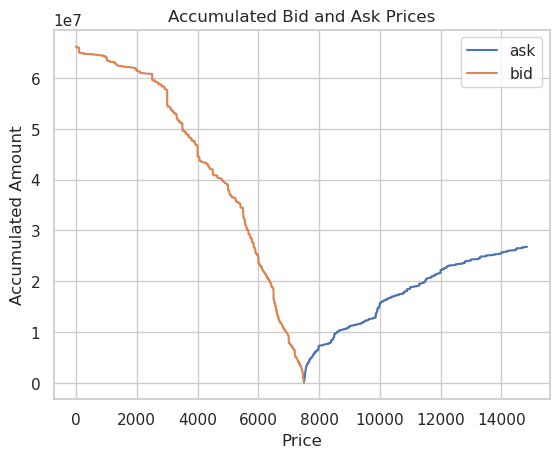

In [17]:
# plot bid and ask prices

sns.lineplot(ask_acc, x="price", y="accumulated_ask", label="ask")
sns.lineplot(bid_acc, x="price", y="accumulated_bid", label="bid")
plt.xlabel("Price")
plt.ylabel("Accumulated Amount")
plt.title("Accumulated Bid and Ask Prices")
plt.legend()
plt.show()

In [18]:
def make_ts_example(timestamp: int):
    ob_single_ts = ob_sample.filter(pl.col("time") == timestamp)

    bid_acc = (
        ob_single_ts.sort(by="price", descending=True)
        .select(pl.col("price"), pl.col("amount"), pl.col("is_bid"))
        .with_columns(
            pl.when(pl.col("is_bid"))
            .then(pl.col("amount") * pl.col("price"))
            .otherwise(None)
            .alias("accumulated_bid"),
        )
        .drop_nulls(subset=["accumulated_bid"])
        .with_columns(
            pl.col("accumulated_bid").cum_sum().alias("accumulated_bid"),
        )
    )

    ask_acc = (
        ob_single_ts.sort(by="price", descending=False)
        .select(pl.col("price"), pl.col("amount"), pl.col("is_bid"))
        .with_columns(
            pl.when(~pl.col("is_bid"))
            .then(pl.col("amount") * pl.col("price"))
            .otherwise(None)
            .alias("accumulated_ask"),
        )
        .drop_nulls(subset=["accumulated_ask"])
        .with_columns(
            pl.col("accumulated_ask").cum_sum().alias("accumulated_ask"),
        )
    )

    return bid_acc.to_pandas(), ask_acc.to_pandas()

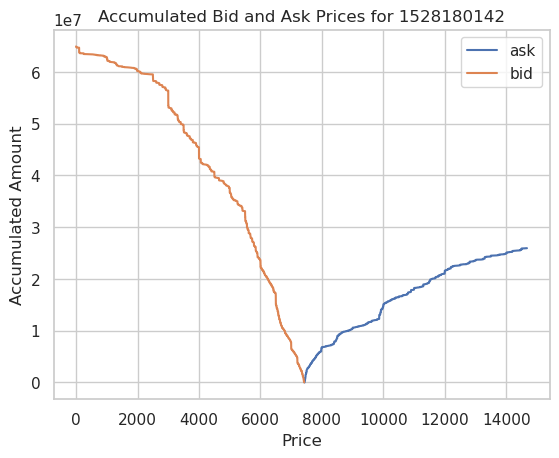

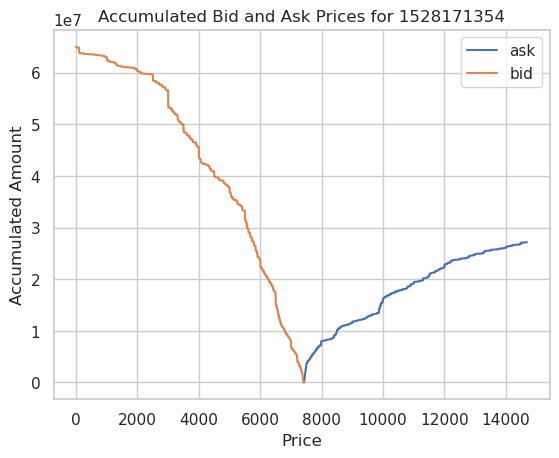

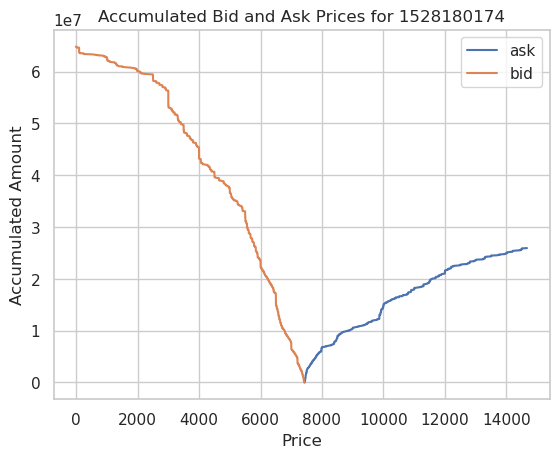

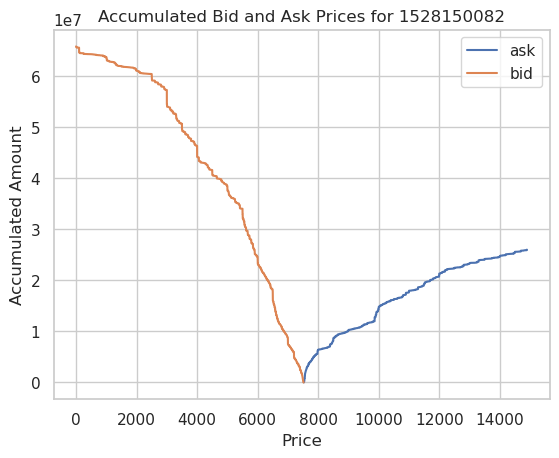

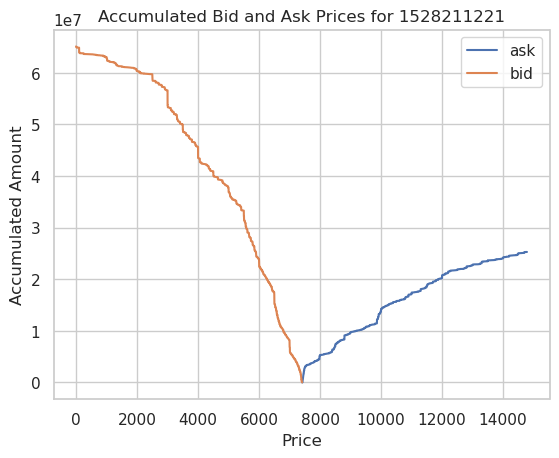

In [19]:
timestamps = np.random.choice(ob_sample["time"].unique(), size=5, replace=False)


for ts in timestamps:
    bid_acc, ask_acc = make_ts_example(ts)
    sns.lineplot(ask_acc, x="price", y="accumulated_ask", label="ask")
    sns.lineplot(bid_acc, x="price", y="accumulated_bid", label="bid")
    plt.xlabel("Price")
    plt.ylabel("Accumulated Amount")
    plt.title(f"Accumulated Bid and Ask Prices for {ts}")
    plt.legend()
    plt.show()

#### Accumulated Depth (count of orders)

In [20]:
bid_acc_vol = (
    ob_single_ts.sort(by="price", descending=True)
    .select(pl.col("price"), pl.col("amount"), pl.col("is_bid"))
    .with_columns(
        pl.when(pl.col("is_bid"))
        .then(pl.col("amount"))
        .otherwise(None)
        .alias("accumulated_bid"),
    )
    .drop_nulls(subset=["accumulated_bid"])
    .with_columns(
        pl.col("accumulated_bid").cum_sum().alias("accumulated_bid"),
    )
)

In [21]:
ask_acc_vol = (
    ob_single_ts.sort(by="price", descending=False)
    .select(pl.col("price"), pl.col("amount"), pl.col("is_bid"))
    .with_columns(
        pl.when(~pl.col("is_bid"))
        .then(pl.col("amount"))
        .otherwise(None)
        .alias("accumulated_ask"),
    )
    .drop_nulls(subset=["accumulated_ask"])
    .with_columns(
        pl.col("accumulated_ask").cum_sum().alias("accumulated_ask"),
    )
)

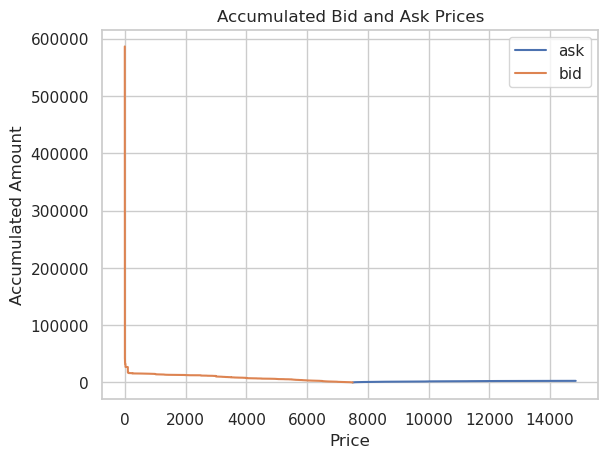

In [22]:
# plot bid and ask prices

sns.lineplot(ask_acc_vol, x="price", y="accumulated_ask", label="ask")
sns.lineplot(bid_acc_vol, x="price", y="accumulated_bid", label="bid")
plt.xlabel("Price")
plt.ylabel("Accumulated Amount")
plt.title("Accumulated Bid and Ask Prices")
plt.legend()
plt.show()

We will filter out bit orders with prices less then USD 100

In [23]:
bid_acc_vol = (
    ob_single_ts.sort(by="price", descending=True)
    .select(pl.col("price"), pl.col("amount"), pl.col("is_bid"))
    .with_columns(
        pl.when(pl.col("is_bid") & (pl.col("price") > 100.0))  ### FILTER
        .then(pl.col("amount"))
        .otherwise(None)
        .alias("accumulated_bid"),
    )
    .drop_nulls(subset=["accumulated_bid"])
    .with_columns(
        pl.col("accumulated_bid").cum_sum().alias("accumulated_bid"),
    )
)

In [24]:
ask_acc_vol = (
    ob_single_ts.sort(by="price", descending=False)
    .select(pl.col("price"), pl.col("amount"), pl.col("is_bid"))
    .with_columns(
        pl.when(~pl.col("is_bid"))
        .then(pl.col("amount"))
        .otherwise(None)
        .alias("accumulated_ask"),
    )
    .drop_nulls(subset=["accumulated_ask"])
    .with_columns(
        pl.col("accumulated_ask").cum_sum().alias("accumulated_ask"),
    )
)

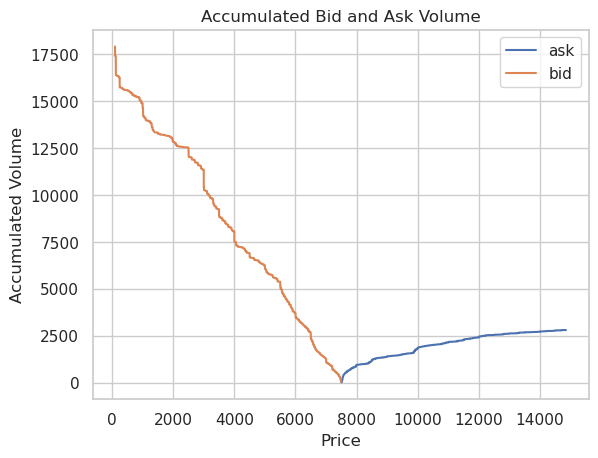

In [25]:
# plot bid and ask prices

sns.lineplot(ask_acc_vol, x="price", y="accumulated_ask", label="ask")
sns.lineplot(bid_acc_vol, x="price", y="accumulated_bid", label="bid")
plt.xlabel("Price")
plt.ylabel("Accumulated Volume")
plt.title("Accumulated Bid and Ask Volume")
plt.legend()
plt.show()

In [26]:
def make_ts_example_acc_vol_filtered(timestamp: int):
    ob_single_ts = ob_sample.filter(pl.col("time") == timestamp)

    bid_acc = (
        ob_single_ts.sort(by="price", descending=True)
        .select(pl.col("price"), pl.col("amount"), pl.col("is_bid"))
        .with_columns(
            pl.when(pl.col("is_bid") & (pl.col("price") > 100.0))  ### FILTER
            .then(pl.col("amount"))
            .otherwise(None)
            .alias("accumulated_bid"),
        )
        .drop_nulls(subset=["accumulated_bid"])
        .with_columns(
            pl.col("accumulated_bid").cum_sum().alias("accumulated_bid"),
        )
    )

    ask_acc = (
        ob_single_ts.sort(by="price", descending=False)
        .select(pl.col("price"), pl.col("amount"), pl.col("is_bid"))
        .with_columns(
            pl.when(~pl.col("is_bid"))
            .then(pl.col("amount"))
            .otherwise(None)
            .alias("accumulated_ask"),
        )
        .drop_nulls(subset=["accumulated_ask"])
        .with_columns(
            pl.col("accumulated_ask").cum_sum().alias("accumulated_ask"),
        )
    )

    return bid_acc.to_pandas(), ask_acc.to_pandas()

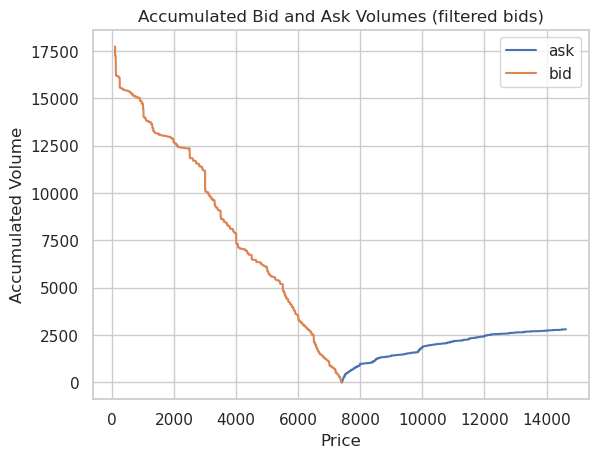

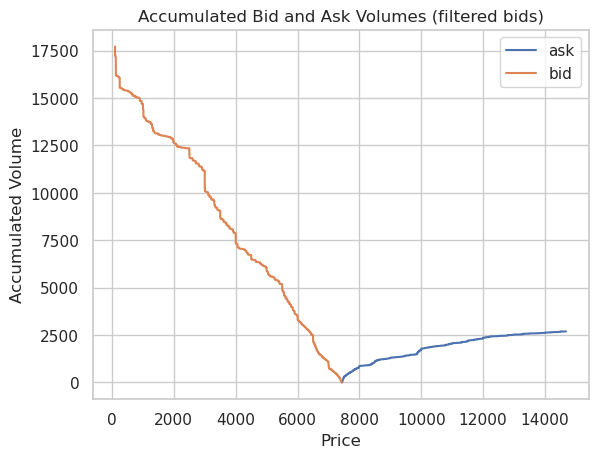

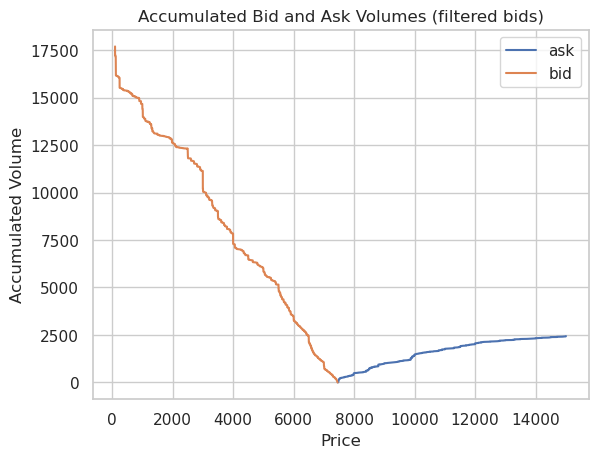

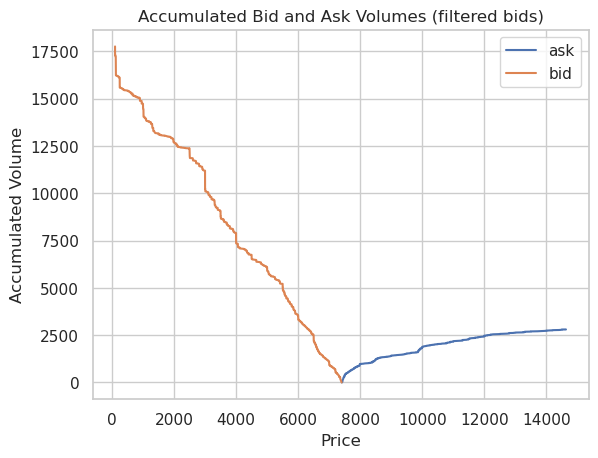

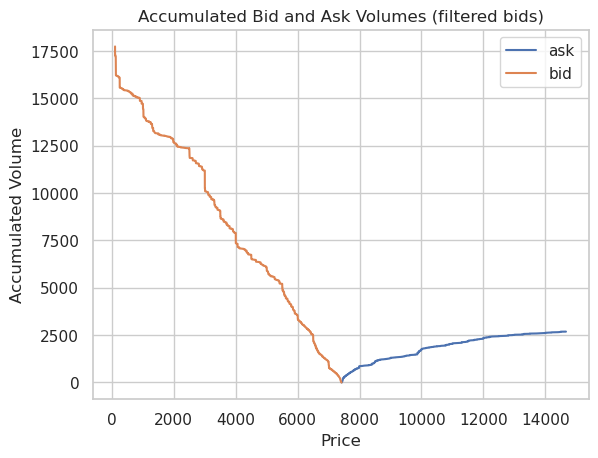

In [27]:
timestamps = np.random.choice(ob_sample["time"].unique(), size=5, replace=False)


for ts in timestamps:
    bid_acc, ask_acc = make_ts_example_acc_vol_filtered(ts)
    sns.lineplot(ask_acc, x="price", y="accumulated_ask", label="ask")
    sns.lineplot(bid_acc, x="price", y="accumulated_bid", label="bid")
    plt.xlabel("Price")
    plt.ylabel("Accumulated Volume")
    plt.title(f"Accumulated Bid and Ask Volumes (filtered bids)")
    plt.legend()
    plt.show()

### Compute: Volume, depth and spread 

In [28]:
time_agg = (
    ob_sample.group_by(["time"])
    .agg(
        pl.when(pl.col("is_bid"))
        .then(pl.col("amount"))
        .otherwise(None)
        .sum()
        .alias("bid_volume"),
        pl.when(~pl.col("is_bid"))
        .then(pl.col("amount"))
        .otherwise(None)
        .sum()
        .alias("ask_volume"),
        pl.when(pl.col("is_bid"))
        .then(pl.col("price"))
        .otherwise(None)
        .max()
        .alias("max_bid"),
        pl.when(~pl.col("is_bid"))
        .then(pl.col("price"))
        .otherwise(None)
        .min()
        .alias("min_ask"),
        pl.when(pl.col("is_bid"))
        .then(pl.col("price"))
        .otherwise(None)
        .count()
        .alias("bid_depth"),
        pl.when(~pl.col("is_bid"))
        .then(pl.col("price"))
        .otherwise(None)
        .count()
        .alias("ask_depth"),
    )
    .cast({"bid_depth": pl.Int32, "ask_depth": pl.Int32})
    .sort("time")
)
time_agg

shape: (2_880, 7)
┌────────────┬───────────────┬─────────────┬─────────┬─────────┬───────────┬───────────┐
│ time       ┆ bid_volume    ┆ ask_volume  ┆ max_bid ┆ min_ask ┆ bid_depth ┆ ask_depth │
│ ---        ┆ ---           ┆ ---         ┆ ---     ┆ ---     ┆ ---       ┆ ---       │
│ i64        ┆ f64           ┆ f64         ┆ f64     ┆ f64     ┆ i32       ┆ i32       │
╞════════════╪═══════════════╪═════════════╪═════════╪═════════╪═══════════╪═══════════╡
│ 1528149602 ┆ 586356.113693 ┆ 2695.804973 ┆ 7537.0  ┆ 7543.19 ┆ 3510      ┆ 5000      │
│ 1528149634 ┆ 586351.269401 ┆ 2696.561478 ┆ 7537.0  ┆ 7543.19 ┆ 3510      ┆ 5000      │
│ 1528149661 ┆ 586350.938081 ┆ 2699.165417 ┆ 7537.0  ┆ 7541.97 ┆ 3510      ┆ 5000      │
│ 1528149693 ┆ 586307.355517 ┆ 2656.934508 ┆ 7537.01 ┆ 7541.97 ┆ 3508      ┆ 5000      │
│ 1528149722 ┆ 586317.596946 ┆ 2657.946212 ┆ 7537.0  ┆ 7541.9  ┆ 3509      ┆ 5000      │
│ …          ┆ …             ┆ …           ┆ …       ┆ …       ┆ …         ┆ …         │
│ 1528235853 ┆ 586359.535387 ┆ 2639.309888 ┆ 7585.02 ┆ 7587.61 ┆ 3560      ┆ 5000      │
│ 1528235881 ┆ 586349.559794 ┆ 2640.391771 ┆ 7586.33 ┆ 7589.52 ┆ 3557      ┆ 5000      │
│ 1528235914 ┆ 586359.035472 ┆ 2639.944562 ┆ 7586.41 ┆ 7589.52 ┆ 3557      ┆ 5000      │
│ 1528235941 ┆ 586355.626546 ┆ 2640.330283 ┆ 7586.41 ┆ 7589.52 ┆ 3556      ┆ 5000      │
│ 1528235974 ┆ 586364.577294 ┆ 2644.44482  ┆ 7586.7  ┆ 7589.52 ┆ 3560      ┆ 5000      │
└────────────┴───────────────┴─────────────┴─────────┴─────────┴───────────┴───────────┘

Let's calculate `spread`, `volume_diff` and `depth_diff`.

In [29]:
time_agg = time_agg.with_columns(
    (pl.col("ask_depth") - pl.col("bid_depth")).alias("depth_diff"),
    (pl.col("min_ask") - pl.col("max_bid")).alias("spread"),
    (pl.col("bid_volume") - pl.col("ask_volume")).alias(
        "volume_diff"
    ),  # bid_vol is always larger
)
time_agg

shape: (2_880, 10)
┌────────────┬────────────┬────────────┬─────────┬───┬───────────┬────────────┬────────┬───────────┐
│ time       ┆ bid_volume ┆ ask_volume ┆ max_bid ┆ … ┆ ask_depth ┆ depth_diff ┆ spread ┆ volume_di │
│ ---        ┆ ---        ┆ ---        ┆ ---     ┆   ┆ ---       ┆ ---        ┆ ---    ┆ ff        │
│ i64        ┆ f64        ┆ f64        ┆ f64     ┆   ┆ i32       ┆ i32        ┆ f64    ┆ ---       │
│            ┆            ┆            ┆         ┆   ┆           ┆            ┆        ┆ f64       │
╞════════════╪════════════╪════════════╪═════════╪═══╪═══════════╪════════════╪════════╪═══════════╡
│ 1528149602 ┆ 586356.113 ┆ 2695.80497 ┆ 7537.0  ┆ … ┆ 5000      ┆ 1490       ┆ 6.19   ┆ 583660.30 │
│            ┆ 693        ┆ 3          ┆         ┆   ┆           ┆            ┆        ┆ 872       │
│ 1528149634 ┆ 586351.269 ┆ 2696.56147 ┆ 7537.0  ┆ … ┆ 5000      ┆ 1490       ┆ 6.19   ┆ 583654.70 │
│            ┆ 401        ┆ 8          ┆         ┆   ┆           ┆            ┆        ┆ 7923      │
│ 1528149661 ┆ 586350.938 ┆ 2699.16541 ┆ 7537.0  ┆ … ┆ 5000      ┆ 1490       ┆ 4.97   ┆ 583651.77 │
│            ┆ 081        ┆ 7          ┆         ┆   ┆           ┆            ┆        ┆ 2664      │
│ 1528149693 ┆ 586307.355 ┆ 2656.93450 ┆ 7537.01 ┆ … ┆ 5000      ┆ 1492       ┆ 4.96   ┆ 583650.42 │
│            ┆ 517        ┆ 8          ┆         ┆   ┆           ┆            ┆        ┆ 1009      │
│ 1528149722 ┆ 586317.596 ┆ 2657.94621 ┆ 7537.0  ┆ … ┆ 5000      ┆ 1491       ┆ 4.9    ┆ 583659.65 │
│            ┆ 946        ┆ 2          ┆         ┆   ┆           ┆            ┆        ┆ 0734      │
│ …          ┆ …          ┆ …          ┆ …       ┆ … ┆ …         ┆ …          ┆ …      ┆ …         │
│ 1528235853 ┆ 586359.535 ┆ 2639.30988 ┆ 7585.02 ┆ … ┆ 5000      ┆ 1440       ┆ 2.59   ┆ 583720.22 │
│            ┆ 387        ┆ 8          ┆         ┆   ┆           ┆            ┆        ┆ 5499      │
│ 1528235881 ┆ 586349.559 ┆ 2640.39177 ┆ 7586.33 ┆ … ┆ 5000      ┆ 1443       ┆ 3.19   ┆ 583709.16 │
│            ┆ 794        ┆ 1          ┆         ┆   ┆           ┆            ┆        ┆ 8023      │
│ 1528235914 ┆ 586359.035 ┆ 2639.94456 ┆ 7586.41 ┆ … ┆ 5000      ┆ 1443       ┆ 3.11   ┆ 583719.09 │
│            ┆ 472        ┆ 2          ┆         ┆   ┆           ┆            ┆        ┆ 091       │
│ 1528235941 ┆ 586355.626 ┆ 2640.33028 ┆ 7586.41 ┆ … ┆ 5000      ┆ 1444       ┆ 3.11   ┆ 583715.29 │
│            ┆ 546        ┆ 3          ┆         ┆   ┆           ┆            ┆        ┆ 6263      │
│ 1528235974 ┆ 586364.577 ┆ 2644.44482 ┆ 7586.7  ┆ … ┆ 5000      ┆ 1440       ┆ 2.82   ┆ 583720.13 │
│            ┆ 294        ┆            ┆         ┆   ┆           ┆            ┆        ┆ 2474      │
└────────────┴────────────┴────────────┴─────────┴───┴───────────┴────────────┴────────┴───────────┘

### Compute: Weighted spread and Slopes

Following are descriptions from the paper
- **Ask/bid slope**: Volume until $\delta$ price, where $\delta_{ask}$ is 10th quantile of the asks and $\delta_{bid}$ is 90th quantile of the bids.
- **Weighted spread**: "difference between cumulative price over 10% of bid depth and cumulative price over 10% of ask depth". This means that we will filter bid orders larger then $\delta_{bid}$, and ask orders smaller then $\delta_{ask}$. Then we will compute the cumulative price over the filtered orders.

In [30]:
# aggregate data over the 10th "percentiles"
time_quantile_agg = ob_sample.group_by(["time"]).agg(
    pl.when(pl.col("is_bid"))
    .then(pl.col("price"))
    .otherwise(None)
    .quantile(0.9)
    .alias("bid_delta"),
    pl.when(~pl.col("is_bid"))
    .then(pl.col("price"))
    .otherwise(None)
    .quantile(0.1)
    .alias("ask_delta"),
)
time_quantile_agg

shape: (2_880, 3)
┌────────────┬───────────┬───────────┐
│ time       ┆ bid_delta ┆ ask_delta │
│ ---        ┆ ---       ┆ ---       │
│ i64        ┆ f64       ┆ f64       │
╞════════════╪═══════════╪═══════════╡
│ 1528234234 ┆ 7136.07   ┆ 8278.87   │
│ 1528179934 ┆ 7047.0    ┆ 8104.47   │
│ 1528192653 ┆ 7040.03   ┆ 8102.75   │
│ 1528224662 ┆ 7150.0    ┆ 8270.0    │
│ 1528186353 ┆ 7030.57   ┆ 8111.0    │
│ …          ┆ …         ┆ …         │
│ 1528193522 ┆ 7049.0    ┆ 8104.47   │
│ 1528179094 ┆ 7049.0    ┆ 8086.43   │
│ 1528218841 ┆ 7100.0    ┆ 8242.0    │
│ 1528182393 ┆ 7040.03   ┆ 8100.0    │
│ 1528201534 ┆ 7030.0    ┆ 8149.09   │
└────────────┴───────────┴───────────┘

In [31]:
ob_tq_agg = pl.concat([ob_sample, time_quantile_agg], how="align_right")
ob_tq_agg

shape: (24_475_306, 6)
┌────────────┬──────────┬──────────┬────────┬───────────┬───────────┐
│ time       ┆ price    ┆ amount   ┆ is_bid ┆ bid_delta ┆ ask_delta │
│ ---        ┆ ---      ┆ ---      ┆ ---    ┆ ---       ┆ ---       │
│ i64        ┆ f64      ┆ f64      ┆ bool   ┆ f64       ┆ f64       │
╞════════════╪══════════╪══════════╪════════╪═══════════╪═══════════╡
│ 1528149602 ┆ 7537.0   ┆ 3.227621 ┆ true   ┆ 7100.29   ┆ 8210.0    │
│ 1528149602 ┆ 7535.15  ┆ 0.1389   ┆ true   ┆ 7100.29   ┆ 8210.0    │
│ 1528149602 ┆ 7532.5   ┆ 0.4056   ┆ true   ┆ 7100.29   ┆ 8210.0    │
│ 1528149602 ┆ 7531.73  ┆ 0.2      ┆ true   ┆ 7100.29   ┆ 8210.0    │
│ 1528149602 ┆ 7530.02  ┆ 0.3      ┆ true   ┆ 7100.29   ┆ 8210.0    │
│ …          ┆ …        ┆ …        ┆ …      ┆ …         ┆ …         │
│ 1528235974 ┆ 15084.0  ┆ 0.076    ┆ false  ┆ 7140.08   ┆ 8279.0    │
│ 1528235974 ┆ 15087.0  ┆ 0.02     ┆ false  ┆ 7140.08   ┆ 8279.0    │
│ 1528235974 ┆ 15088.0  ┆ 0.0744   ┆ false  ┆ 7140.08   ┆ 8279.0    │
│ 1528235974 ┆ 15091.44 ┆ 0.008    ┆ false  ┆ 7140.08   ┆ 8279.0    │
│ 1528235974 ┆ 15095.0  ┆ 1.21     ┆ false  ┆ 7140.08   ┆ 8279.0    │
└────────────┴──────────┴──────────┴────────┴───────────┴───────────┘

In [32]:
ob_tq_agg.filter(pl.col("time") == timestamp[0])

shape: (8_513, 6)
┌────────────┬──────────┬───────────┬────────┬───────────┬───────────┐
│ time       ┆ price    ┆ amount    ┆ is_bid ┆ bid_delta ┆ ask_delta │
│ ---        ┆ ---      ┆ ---       ┆ ---    ┆ ---       ┆ ---       │
│ i64        ┆ f64      ┆ f64       ┆ bool   ┆ f64       ┆ f64       │
╞════════════╪══════════╪═══════════╪════════╪═══════════╪═══════════╡
│ 1528153441 ┆ 7500.0   ┆ 30.270179 ┆ true   ┆ 7103.74   ┆ 8166.07   │
│ 1528153441 ┆ 7498.95  ┆ 1.0       ┆ true   ┆ 7103.74   ┆ 8166.07   │
│ 1528153441 ┆ 7497.85  ┆ 0.01      ┆ true   ┆ 7103.74   ┆ 8166.07   │
│ 1528153441 ┆ 7493.62  ┆ 8.556     ┆ true   ┆ 7103.74   ┆ 8166.07   │
│ 1528153441 ┆ 7493.52  ┆ 5.87      ┆ true   ┆ 7103.74   ┆ 8166.07   │
│ …          ┆ …        ┆ …         ┆ …      ┆ …         ┆ …         │
│ 1528153441 ┆ 14827.0  ┆ 0.04      ┆ false  ┆ 7103.74   ┆ 8166.07   │
│ 1528153441 ┆ 14833.0  ┆ 0.174     ┆ false  ┆ 7103.74   ┆ 8166.07   │
│ 1528153441 ┆ 14838.35 ┆ 0.000518  ┆ false  ┆ 7103.74   ┆ 8166.07   │
│ 1528153441 ┆ 14839.21 ┆ 0.04      ┆ false  ┆ 7103.74   ┆ 8166.07   │
│ 1528153441 ┆ 14844.75 ┆ 0.002     ┆ false  ┆ 7103.74   ┆ 8166.07   │
└────────────┴──────────┴───────────┴────────┴───────────┴───────────┘

In [33]:
time_agg_weighted = (
    pl.concat([ob_sample, time_quantile_agg], how="align_right")
    .group_by(["time"])
    .agg(
        pl.when(pl.col("is_bid") & (pl.col("price") >= pl.col("bid_delta")))
        .then(pl.col("amount"))
        .otherwise(0.0)
        .sum()
        .alias("bid_slope"),
        pl.when(~pl.col("is_bid") & (pl.col("price") <= pl.col("ask_delta")))
        .then(pl.col("amount"))
        .otherwise(0.0)
        .sum()
        .alias("ask_slope"),
        pl.when(pl.col("is_bid") & (pl.col("price") >= pl.col("bid_delta")))
        .then(pl.col("price"))
        .otherwise(None)
        .min()
        .alias("weighted_bid"),
        pl.when(~pl.col("is_bid") & (pl.col("price") <= pl.col("ask_delta")))
        .then(pl.col("price"))
        .otherwise(None)
        .max()
        .alias("weighted_ask"),
    )
    .with_columns(
        (pl.col("weighted_ask") - pl.col("weighted_bid")).alias("weighted_spread"),
    )
)
time_agg_weighted

shape: (2_880, 6)
┌────────────┬─────────────┬────────────┬──────────────┬──────────────┬─────────────────┐
│ time       ┆ bid_slope   ┆ ask_slope  ┆ weighted_bid ┆ weighted_ask ┆ weighted_spread │
│ ---        ┆ ---         ┆ ---        ┆ ---          ┆ ---          ┆ ---             │
│ i64        ┆ f64         ┆ f64        ┆ f64          ┆ f64          ┆ f64             │
╞════════════╪═════════════╪════════════╪══════════════╪══════════════╪═════════════════╡
│ 1528149602 ┆ 934.466054  ┆ 868.789883 ┆ 7100.29      ┆ 8210.0       ┆ 1109.71         │
│ 1528149634 ┆ 929.621762  ┆ 869.597349 ┆ 7100.29      ┆ 8204.47      ┆ 1104.18         │
│ 1528149661 ┆ 929.290442  ┆ 872.151288 ┆ 7100.29      ┆ 8203.44      ┆ 1103.15         │
│ 1528149693 ┆ 894.15346   ┆ 829.919417 ┆ 7099.0       ┆ 8210.0       ┆ 1111.0          │
│ 1528149722 ┆ 903.394889  ┆ 830.982083 ┆ 7100.0       ┆ 8204.47      ┆ 1104.47         │
│ …          ┆ …           ┆ …          ┆ …            ┆ …            ┆ …               │
│ 1528235853 ┆ 1008.843487 ┆ 711.932457 ┆ 7140.08      ┆ 8284.42      ┆ 1144.34         │
│ 1528235881 ┆ 1003.168735 ┆ 713.01434  ┆ 7134.59      ┆ 8284.42      ┆ 1149.83         │
│ 1528235914 ┆ 1003.242941 ┆ 712.566581 ┆ 7134.59      ┆ 8286.62      ┆ 1152.03         │
│ 1528235941 ┆ 999.834015  ┆ 712.952852 ┆ 7134.59      ┆ 8284.42      ┆ 1149.83         │
│ 1528235974 ┆ 1004.483922 ┆ 715.349094 ┆ 7140.08      ┆ 8279.0       ┆ 1138.92         │
└────────────┴─────────────┴────────────┴──────────────┴──────────────┴─────────────────┘

In [34]:
agg_df = pl.concat([time_agg, time_agg_weighted], how="align").sort("time")
agg_df

shape: (2_880, 15)
┌────────────┬───────────┬───────────┬─────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ time       ┆ bid_volum ┆ ask_volum ┆ max_bid ┆ … ┆ ask_slope ┆ weighted_ ┆ weighted_ ┆ weighted_ │
│ ---        ┆ e         ┆ e         ┆ ---     ┆   ┆ ---       ┆ bid       ┆ ask       ┆ spread    │
│ i64        ┆ ---       ┆ ---       ┆ f64     ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---       │
│            ┆ f64       ┆ f64       ┆         ┆   ┆           ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪═══════════╪═══════════╪═════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1528149602 ┆ 586356.11 ┆ 2695.8049 ┆ 7537.0  ┆ … ┆ 868.78988 ┆ 7100.29   ┆ 8210.0    ┆ 1109.71   │
│            ┆ 3693      ┆ 73        ┆         ┆   ┆ 3         ┆           ┆           ┆           │
│ 1528149634 ┆ 586351.26 ┆ 2696.5614 ┆ 7537.0  ┆ … ┆ 869.59734 ┆ 7100.29   ┆ 8204.47   ┆ 1104.18   │
│            ┆ 9401      ┆ 78        ┆         ┆   ┆ 9         ┆           ┆           ┆           │
│ 1528149661 ┆ 586350.93 ┆ 2699.1654 ┆ 7537.0  ┆ … ┆ 872.15128 ┆ 7100.29   ┆ 8203.44   ┆ 1103.15   │
│            ┆ 8081      ┆ 17        ┆         ┆   ┆ 8         ┆           ┆           ┆           │
│ 1528149693 ┆ 586307.35 ┆ 2656.9345 ┆ 7537.01 ┆ … ┆ 829.91941 ┆ 7099.0    ┆ 8210.0    ┆ 1111.0    │
│            ┆ 5517      ┆ 08        ┆         ┆   ┆ 7         ┆           ┆           ┆           │
│ 1528149722 ┆ 586317.59 ┆ 2657.9462 ┆ 7537.0  ┆ … ┆ 830.98208 ┆ 7100.0    ┆ 8204.47   ┆ 1104.47   │
│            ┆ 6946      ┆ 12        ┆         ┆   ┆ 3         ┆           ┆           ┆           │
│ …          ┆ …         ┆ …         ┆ …       ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 1528235853 ┆ 586359.53 ┆ 2639.3098 ┆ 7585.02 ┆ … ┆ 711.93245 ┆ 7140.08   ┆ 8284.42   ┆ 1144.34   │
│            ┆ 5387      ┆ 88        ┆         ┆   ┆ 7         ┆           ┆           ┆           │
│ 1528235881 ┆ 586349.55 ┆ 2640.3917 ┆ 7586.33 ┆ … ┆ 713.01434 ┆ 7134.59   ┆ 8284.42   ┆ 1149.83   │
│            ┆ 9794      ┆ 71        ┆         ┆   ┆           ┆           ┆           ┆           │
│ 1528235914 ┆ 586359.03 ┆ 2639.9445 ┆ 7586.41 ┆ … ┆ 712.56658 ┆ 7134.59   ┆ 8286.62   ┆ 1152.03   │
│            ┆ 5472      ┆ 62        ┆         ┆   ┆ 1         ┆           ┆           ┆           │
│ 1528235941 ┆ 586355.62 ┆ 2640.3302 ┆ 7586.41 ┆ … ┆ 712.95285 ┆ 7134.59   ┆ 8284.42   ┆ 1149.83   │
│            ┆ 6546      ┆ 83        ┆         ┆   ┆ 2         ┆           ┆           ┆           │
│ 1528235974 ┆ 586364.57 ┆ 2644.4448 ┆ 7586.7  ┆ … ┆ 715.34909 ┆ 7140.08   ┆ 8279.0    ┆ 1138.92   │
│            ┆ 7294      ┆ 2         ┆         ┆   ┆ 4         ┆           ┆           ┆           │
└────────────┴───────────┴───────────┴─────────┴───┴───────────┴───────────┴───────────┴───────────┘

## Inspect features

In [35]:
agg_df.describe()

shape: (9, 16)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ time      ┆ bid_volum ┆ ask_volum ┆ … ┆ ask_slope ┆ weighted_ ┆ weighted_ ┆ weighted │
│ ---       ┆ ---       ┆ e         ┆ e         ┆   ┆ ---       ┆ bid       ┆ ask       ┆ _spread  │
│ str       ┆ f64       ┆ ---       ┆ ---       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆ f64       ┆   ┆           ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 2880.0    ┆ 2880.0    ┆ 2880.0    ┆ … ┆ 2880.0    ┆ 2880.0    ┆ 2880.0    ┆ 2880.0   │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ 1.5282e9  ┆ 586312.87 ┆ 2695.9276 ┆ … ┆ 830.93147 ┆ 7070.1165 ┆ 8164.8701 ┆ 1094.753 │
│           ┆           ┆ 7728      ┆ 51        ┆   ┆ 1         ┆ 42        ┆ 32        ┆ 59       │
│ std       ┆ 24945.947 ┆ 141.22439 ┆ 88.324994 ┆ … ┆ 120.88798 ┆ 48.060795 ┆ 64.537974 ┆ 35.79080 │
│           ┆ 957       ┆ 7         ┆           ┆   ┆ 7         ┆           ┆           ┆ 5        │
│ min       ┆ 1.5281e9  ┆ 585993.79 ┆ 2384.1756 ┆ … ┆ 461.48041 ┆ 6988.89   ┆ 8042.9    ┆ 1018.2   │
│           ┆           ┆ 7821      ┆ 5         ┆   ┆ 1         ┆           ┆           ┆          │
│ 25%       ┆ 1.5282e9  ┆ 586221.28 ┆ 2624.7508 ┆ … ┆ 718.87598 ┆ 7029.7    ┆ 8111.0    ┆ 1064.7   │
│           ┆           ┆ 6234      ┆ 28        ┆   ┆ 1         ┆           ┆           ┆          │
│ 50%       ┆ 1.5282e9  ┆ 586272.51 ┆ 2699.2068 ┆ … ┆ 853.69067 ┆ 7050.0    ┆ 8146.0    ┆ 1087.7   │
│           ┆           ┆ 4858      ┆ 62        ┆   ┆ 4         ┆           ┆           ┆          │
│ 75%       ┆ 1.5282e9  ┆ 586362.61 ┆ 2761.7840 ┆ … ┆ 942.26606 ┆ 7103.74   ┆ 8210.0    ┆ 1125.26  │
│           ┆           ┆ 3259      ┆ 55        ┆   ┆ 2         ┆           ┆           ┆          │
│ max       ┆ 1.5282e9  ┆ 586715.85 ┆ 2910.6494 ┆ … ┆ 1078.8580 ┆ 7181.0    ┆ 8400.9    ┆ 1287.31  │
│           ┆           ┆ 9347      ┆ 91        ┆   ┆ 34        ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

The number of ask quotes was probably limited to 5000 during the fetching of the data.

For this reason, `ask_depth` is always 5000, and `bid_depth` will be equal to `depth_diff`+5000, thus **we expect the following features to be redundant**:
- **ask_depth**, as it is equal to 5000
- **depth_diff**, as it is equal to `bid_depth` - 5000

### Where are $\delta_{ask}$ and $\delta_{bid}$?

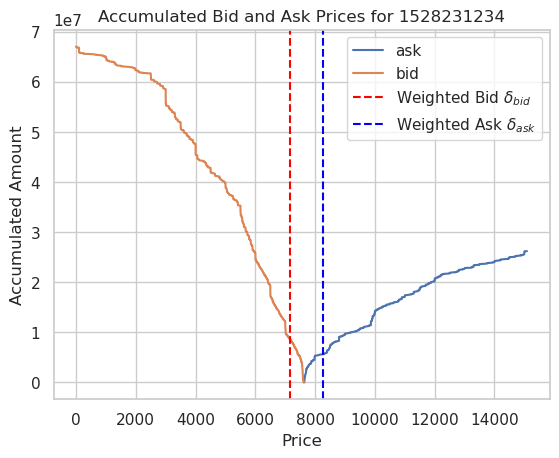

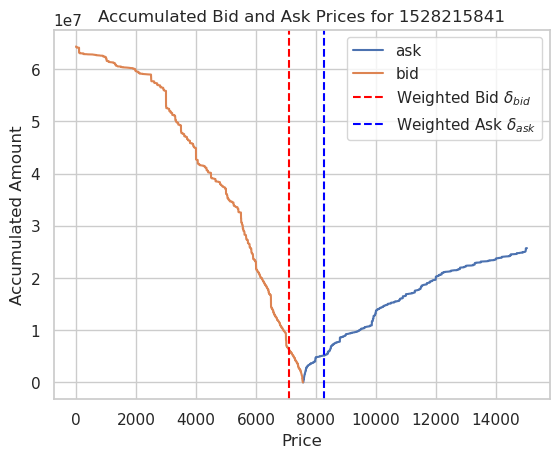

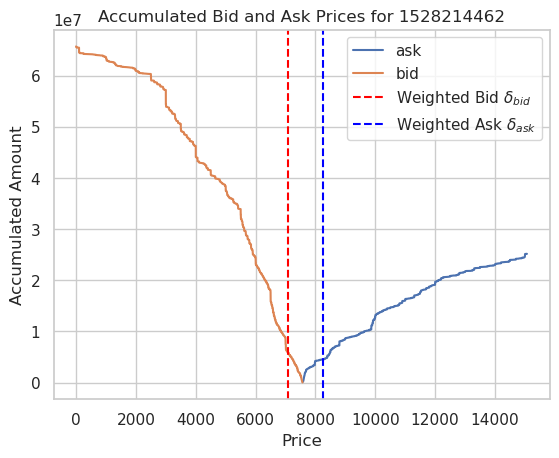

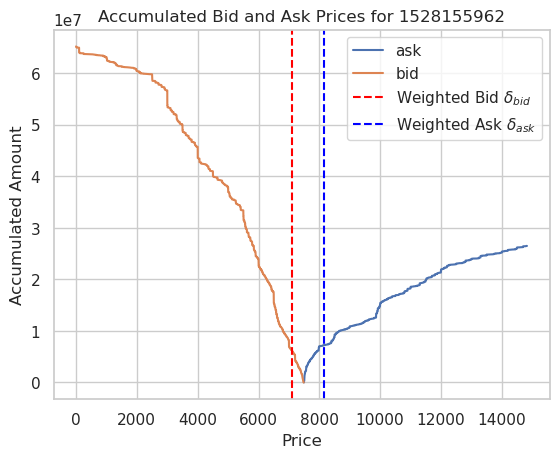

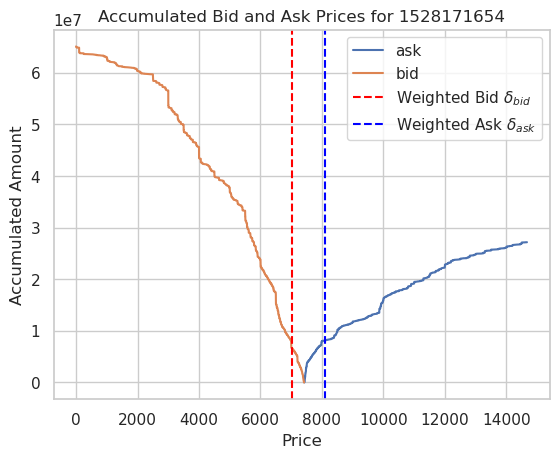

In [36]:
timestamps = np.random.choice(ob_sample["time"].unique(), size=5, replace=False)


for ts in timestamps:
    bid_acc, ask_acc = make_ts_example(ts)
    sns.lineplot(ask_acc, x="price", y="accumulated_ask", label="ask")
    sns.lineplot(bid_acc, x="price", y="accumulated_bid", label="bid")

    plt.axvline(
        x=agg_df.filter(pl.col("time") == ts)["weighted_bid"].to_numpy()[0],
        color="red",
        linestyle="--",
        label=r"Weighted Bid $\delta_{bid}$",
    )
    plt.axvline(
        x=agg_df.filter(pl.col("time") == ts)["weighted_ask"].to_numpy()[0],
        color="blue",
        linestyle="--",
        label=r"Weighted Ask $\delta_{ask}$",
    )

    plt.xlabel("Price")
    plt.ylabel("Accumulated Amount")
    plt.title(f"Accumulated Bid and Ask Prices for {ts}")

    # zoom in
    # plt.xlim(agg_df.filter(pl.col('time') == ts)['weighted_bid'].to_numpy()[0] - 2000, agg_df.filter(pl.col('time') == ts)['weighted_ask'].to_numpy()[0] + 2000)
    plt.legend()
    plt.show()

### Time evolution (over a single day)

In [37]:
# sort by time
agg_df = agg_df.sort("time")

<Axes: xlabel='time', ylabel='weighted_spread'>

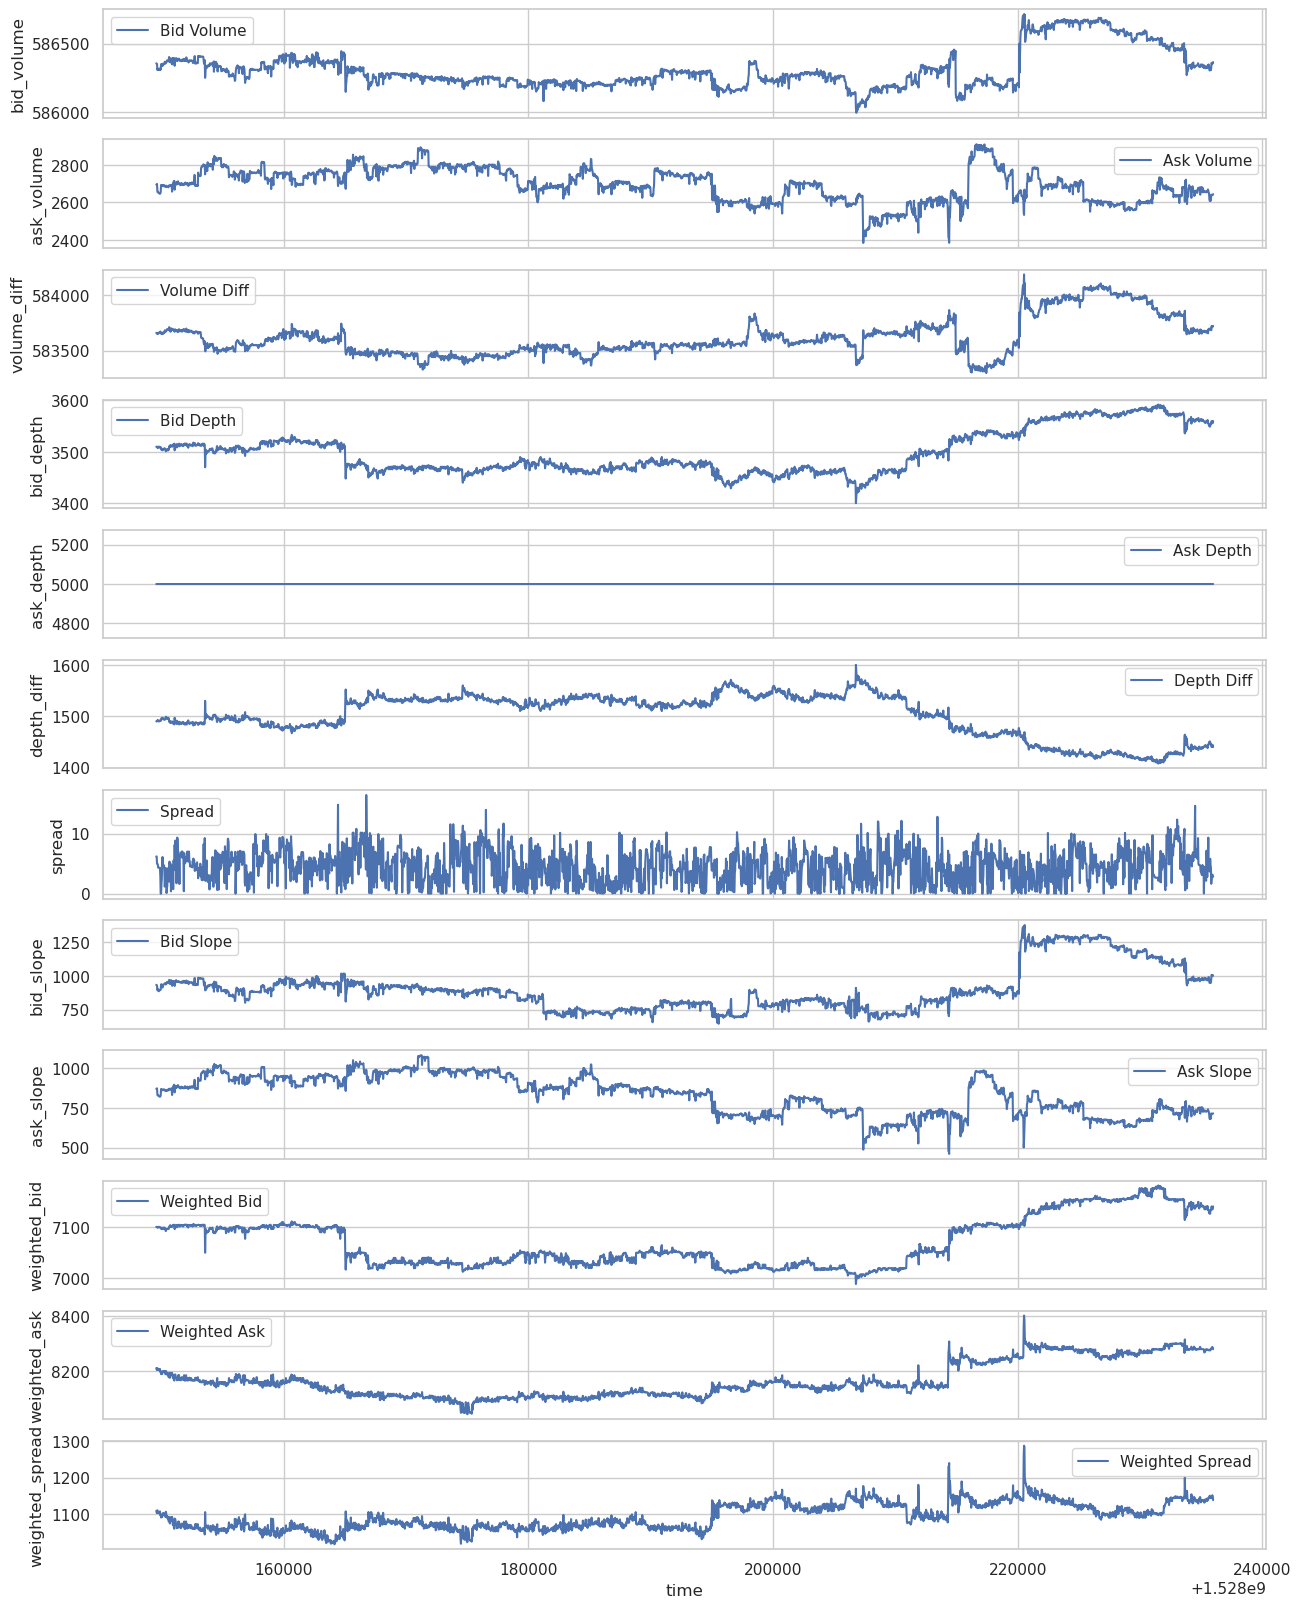

In [38]:
fig, ax = plt.subplots(12, 1, figsize=(15, 20), sharex=True)

# plot bid and ask volume
sns.lineplot(data=agg_df, x="time", y="bid_volume", ax=ax[0], label="Bid Volume")
sns.lineplot(data=agg_df, x="time", y="ask_volume", ax=ax[1], label="Ask Volume")
sns.lineplot(data=agg_df, x="time", y="volume_diff", ax=ax[2], label="Volume Diff")
sns.lineplot(data=agg_df, x="time", y="bid_depth", ax=ax[3], label="Bid Depth")
sns.lineplot(data=agg_df, x="time", y="ask_depth", ax=ax[4], label="Ask Depth")
sns.lineplot(data=agg_df, x="time", y="depth_diff", ax=ax[5], label="Depth Diff")
sns.lineplot(data=agg_df, x="time", y="spread", ax=ax[6], label="Spread")
sns.lineplot(data=agg_df, x="time", y="bid_slope", ax=ax[7], label="Bid Slope")
sns.lineplot(data=agg_df, x="time", y="ask_slope", ax=ax[8], label="Ask Slope")
sns.lineplot(data=agg_df, x="time", y="weighted_bid", ax=ax[9], label="Weighted Bid")
sns.lineplot(data=agg_df, x="time", y="weighted_ask", ax=ax[10], label="Weighted Ask")
sns.lineplot(
    data=agg_df, x="time", y="weighted_spread", ax=ax[11], label="Weighted Spread"
)

### Correlations

In [39]:
agg_df

shape: (2_880, 15)
┌────────────┬───────────┬───────────┬─────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ time       ┆ bid_volum ┆ ask_volum ┆ max_bid ┆ … ┆ ask_slope ┆ weighted_ ┆ weighted_ ┆ weighted_ │
│ ---        ┆ e         ┆ e         ┆ ---     ┆   ┆ ---       ┆ bid       ┆ ask       ┆ spread    │
│ i64        ┆ ---       ┆ ---       ┆ f64     ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---       │
│            ┆ f64       ┆ f64       ┆         ┆   ┆           ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪═══════════╪═══════════╪═════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1528149602 ┆ 586356.11 ┆ 2695.8049 ┆ 7537.0  ┆ … ┆ 868.78988 ┆ 7100.29   ┆ 8210.0    ┆ 1109.71   │
│            ┆ 3693      ┆ 73        ┆         ┆   ┆ 3         ┆           ┆           ┆           │
│ 1528149634 ┆ 586351.26 ┆ 2696.5614 ┆ 7537.0  ┆ … ┆ 869.59734 ┆ 7100.29   ┆ 8204.47   ┆ 1104.18   │
│            ┆ 9401      ┆ 78        ┆         ┆   ┆ 9         ┆           ┆           ┆           │
│ 1528149661 ┆ 586350.93 ┆ 2699.1654 ┆ 7537.0  ┆ … ┆ 872.15128 ┆ 7100.29   ┆ 8203.44   ┆ 1103.15   │
│            ┆ 8081      ┆ 17        ┆         ┆   ┆ 8         ┆           ┆           ┆           │
│ 1528149693 ┆ 586307.35 ┆ 2656.9345 ┆ 7537.01 ┆ … ┆ 829.91941 ┆ 7099.0    ┆ 8210.0    ┆ 1111.0    │
│            ┆ 5517      ┆ 08        ┆         ┆   ┆ 7         ┆           ┆           ┆           │
│ 1528149722 ┆ 586317.59 ┆ 2657.9462 ┆ 7537.0  ┆ … ┆ 830.98208 ┆ 7100.0    ┆ 8204.47   ┆ 1104.47   │
│            ┆ 6946      ┆ 12        ┆         ┆   ┆ 3         ┆           ┆           ┆           │
│ …          ┆ …         ┆ …         ┆ …       ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 1528235853 ┆ 586359.53 ┆ 2639.3098 ┆ 7585.02 ┆ … ┆ 711.93245 ┆ 7140.08   ┆ 8284.42   ┆ 1144.34   │
│            ┆ 5387      ┆ 88        ┆         ┆   ┆ 7         ┆           ┆           ┆           │
│ 1528235881 ┆ 586349.55 ┆ 2640.3917 ┆ 7586.33 ┆ … ┆ 713.01434 ┆ 7134.59   ┆ 8284.42   ┆ 1149.83   │
│            ┆ 9794      ┆ 71        ┆         ┆   ┆           ┆           ┆           ┆           │
│ 1528235914 ┆ 586359.03 ┆ 2639.9445 ┆ 7586.41 ┆ … ┆ 712.56658 ┆ 7134.59   ┆ 8286.62   ┆ 1152.03   │
│            ┆ 5472      ┆ 62        ┆         ┆   ┆ 1         ┆           ┆           ┆           │
│ 1528235941 ┆ 586355.62 ┆ 2640.3302 ┆ 7586.41 ┆ … ┆ 712.95285 ┆ 7134.59   ┆ 8284.42   ┆ 1149.83   │
│            ┆ 6546      ┆ 83        ┆         ┆   ┆ 2         ┆           ┆           ┆           │
│ 1528235974 ┆ 586364.57 ┆ 2644.4448 ┆ 7586.7  ┆ … ┆ 715.34909 ┆ 7140.08   ┆ 8279.0    ┆ 1138.92   │
│            ┆ 7294      ┆ 2         ┆         ┆   ┆ 4         ┆           ┆           ┆           │
└────────────┴───────────┴───────────┴─────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [40]:
# compute correlation between features
corr = (
    agg_df.select(
        pl.col("bid_volume"),
        pl.col("ask_volume"),
        pl.col("volume_diff"),
        pl.col("bid_depth"),
        pl.col("spread"),
        # pl.col('ask_depth'), # constant = 5000
        # pl.col('depth_diff'), # = bid_depth - 5000
        pl.col("bid_slope"),
        pl.col("ask_slope"),
        pl.col("weighted_bid"),
        pl.col("weighted_ask"),
        pl.col("weighted_spread"),
    )
    .to_pandas()
    .corr()
)

In [41]:
corr

bid_volume  ask_volume  volume_diff  bid_depth    spread  \
bid_volume         1.000000   -0.050423     0.855398   0.820543  0.068958   
ask_volume        -0.050423    1.000000    -0.560444  -0.037563  0.098426   
volume_diff        0.855398   -0.560444     1.000000   0.699914  0.006136   
bid_depth          0.820543   -0.037563     0.699914   1.000000  0.091296   
spread             0.068958    0.098426     0.006136   0.091296  1.000000   
bid_slope          0.925976    0.059597     0.736954   0.838629  0.101168   
ask_slope         -0.197572    0.931411    -0.646894  -0.231342  0.086155   
weighted_bid       0.808730   -0.001329     0.671327   0.983970  0.098157   
weighted_ask       0.678449   -0.298424     0.717374   0.865939  0.036873   
weighted_spread    0.137396   -0.536333     0.392094   0.240162 -0.065318   

                 bid_slope  ask_slope  weighted_bid  weighted_ask  \
bid_volume        0.925976  -0.197572      0.808730      0.678449   
ask_volume        0.059597   0.931411     -0.001329     -0.298424   
volume_diff       0.736954  -0.646894      0.671327      0.717374   
bid_depth         0.838629  -0.231342      0.983970      0.865939   
spread            0.101168   0.086155      0.098157      0.036873   
bid_slope         1.000000  -0.112989      0.822396      0.728448   
ask_slope        -0.112989   1.000000     -0.171634     -0.523672   
weighted_bid      0.822396  -0.171634      1.000000      0.837272   
weighted_ask      0.728448  -0.523672      0.837272      1.000000   
weighted_spread   0.209203  -0.713810      0.166943      0.678890   

                 weighted_spread  
bid_volume              0.137396  
ask_volume             -0.536333  
volume_diff             0.392094  
bid_depth               0.240162  
spread                 -0.065318  
bid_slope               0.209203  
ask_slope              -0.713810  
weighted_bid            0.166943  
weighted_ask            0.678890  
weighted_spread         1.000000

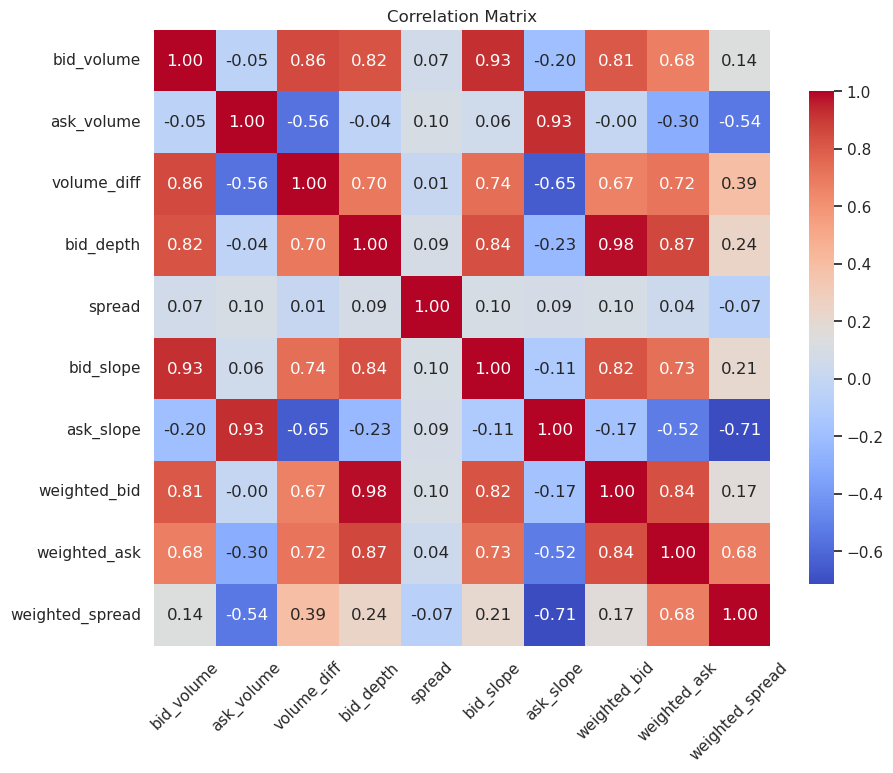

In [42]:
# plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr, annot=True, cmap="coolwarm", fmt=".2f", square=True, cbar_kws={"shrink": 0.8}
)
plt.xticks(rotation=45)
plt.title("Correlation Matrix")
plt.show()

In [43]:
cov = (
    agg_df.select(
        pl.col("bid_volume"),
        pl.col("ask_volume"),
        pl.col("volume_diff"),
        pl.col("bid_depth"),
        pl.col("spread"),
        # pl.col('ask_depth'), # constant = 5000
        # pl.col('depth_diff'), # = bid_depth - 5000
        pl.col("bid_slope"),
        pl.col("ask_slope"),
        pl.col("weighted_bid"),
        pl.col("weighted_ask"),
        pl.col("weighted_spread"),
    )
    .to_pandas()
    .cov()
)

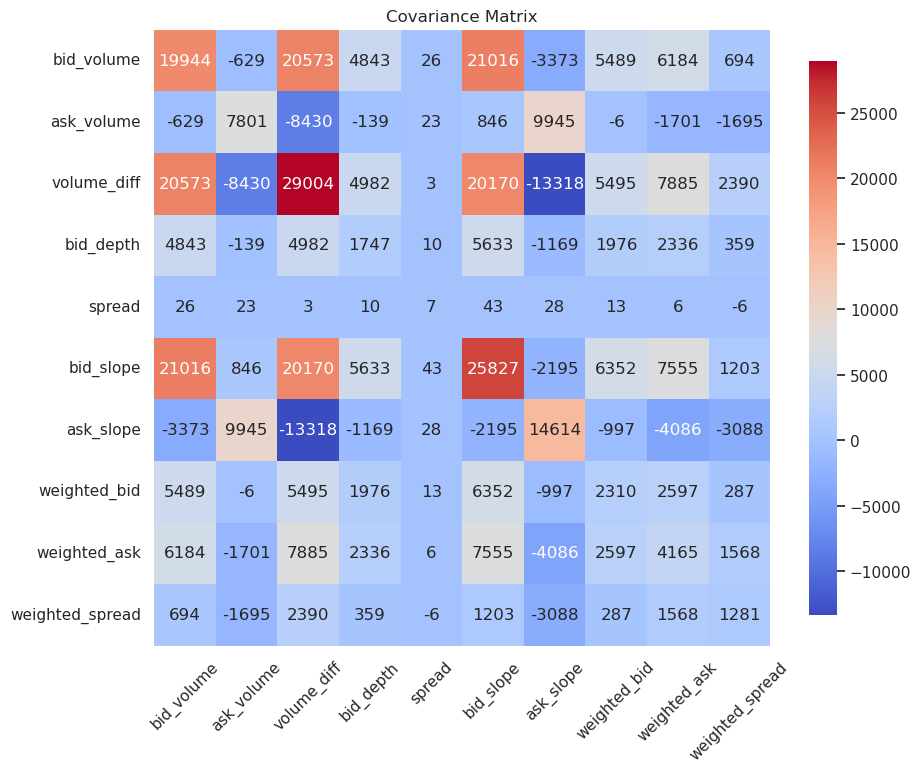

In [44]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    cov, annot=True, cmap="coolwarm", fmt=".0f", square=True, cbar_kws={"shrink": 0.9}
)
plt.xticks(rotation=45)
plt.title("Covariance Matrix")
plt.show()

## Conclusions

- `ask_depth` is constant =5000, and `depth_diff` are redundant as it is equal to `bid_depth` - 5000.
- `bid_depth` is inflated by the number of orders with price close to 0. This makes the `bid_depth` less informative about what is happening around the current price.

# Oreder book data - multiple bitstamps merged 

The logic of calculations in this notebook are the same as the ones in the `1.0-mz-eda.ipynb` notebook. The only difference is that this notebook loops through all the files in the `data/` directory and computes the OB features for each file. The results are saved in a new directory called `data/output`.

In [45]:
csv_files = list(raw_data_path.glob("bitstamp_ob*.zip"))
csv_files[:5]

[PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_ob_25_06_2018.zip'),
 PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_ob_22_06_2018.zip'),
 PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_ob_18_06_2018.zip'),
 PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_ob_05_09_2018.zip'),
 PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_ob_05_06_2018.zip')]

In [46]:
# aggregate data over the 10th "percentiles"
thr = 0.2
time_quantile_agg = ob_sample.group_by(["time"]).agg(
    pl.when(pl.col("is_bid"))
    .then(pl.col("price"))
    .otherwise(None)
    .quantile(1 - thr)
    .alias("bid_delta"),
    pl.when(~pl.col("is_bid"))
    .then(pl.col("price"))
    .otherwise(None)
    .quantile(thr)
    .alias("ask_delta"),
)
time_quantile_agg

shape: (2_880, 3)
┌────────────┬───────────┬───────────┐
│ time       ┆ bid_delta ┆ ask_delta │
│ ---        ┆ ---       ┆ ---       │
│ i64        ┆ f64       ┆ f64       │
╞════════════╪═══════════╪═══════════╡
│ 1528226734 ┆ 6748.08   ┆ 8978.39   │
│ 1528190161 ┆ 6659.0    ┆ 8912.0    │
│ 1528163553 ┆ 6674.6    ┆ 8917.39   │
│ 1528172973 ┆ 6645.95   ┆ 8890.31   │
│ 1528197634 ┆ 6621.12   ┆ 8916.0    │
│ …          ┆ …         ┆ …         │
│ 1528199161 ┆ 6636.0    ┆ 8922.39   │
│ 1528149634 ┆ 6679.42   ┆ 8947.8    │
│ 1528199554 ┆ 6625.51   ┆ 8936.0    │
│ 1528203901 ┆ 6621.12   ┆ 8915.58   │
│ 1528234534 ┆ 6727.0    ┆ 8990.59   │
└────────────┴───────────┴───────────┘

In [ ]:
dataframes = []

filtering_quantile_threshold = (
    0.2  # 20% quantile for filtering, in line with Vi's script
)
depth_quantile_threshold = 0.1  # 10% quantile for depth calculation

for csv_file in tqdm(csv_files, desc="Processing CSV files"):
    # load and format
    ob_sample = (
        pl.read_csv(
            ZipFile(raw_data_path / csv_file.name).read(csv_file.name[:-4] + ".csv")
        )
        .with_columns((pl.col("type") == "b").alias("is_bid"))
        .drop("type")
        .rename({"amount ": "amount"})
    )

    # aggregate data from the original dataframe over the 10th "percentiles"
    filter_quantiles = ob_sample.group_by(["time"]).agg(
        pl.when(pl.col("is_bid"))
        .then(pl.col("price"))
        .otherwise(None)
        .quantile(filtering_quantile_threshold)
        .alias("bid_filter"),
        pl.when(~pl.col("is_bid"))
        .then(pl.col("price"))
        .otherwise(None)
        .quantile(1 - filtering_quantile_threshold)
        .alias("ask_filter"),
    )

    # filter out rows where the price is below the 20th percentile for bids and above the 80th
    # percentile for asks
    ob_sample = (
        pl.concat([ob_sample, filter_quantiles], how="align_right")
        .filter(
            (pl.col("is_bid") & (pl.col("price") >= pl.col("bid_filter")))
            | (~pl.col("is_bid") & (pl.col("price") <= pl.col("ask_filter")))
        )
        .drop(["bid_filter", "ask_filter"])
    )

    # aggregate data from the original dataframe over the 10th "percentiles"
    time_quantile_agg = ob_sample.group_by(["time"]).agg(
        pl.when(pl.col("is_bid"))
        .then(pl.col("price"))
        .otherwise(None)
        .quantile(1 - depth_quantile_threshold)
        .alias("bid_delta"),
        pl.when(~pl.col("is_bid"))
        .then(pl.col("price"))
        .otherwise(None)
        .quantile(depth_quantile_threshold)
        .alias("ask_delta"),
    )

    # calculate volume, depth, spread, volume_diff, and depth_diff
    time_agg = (
        pl.concat([ob_sample, time_quantile_agg], how="align_right")
        .group_by(["time"])
        .agg(
            pl.when(pl.col("is_bid"))
            .then(pl.col("amount"))
            .otherwise(None)
            .sum()
            .alias("bid_volume"),
            pl.when(~pl.col("is_bid"))
            .then(pl.col("amount"))
            .otherwise(None)
            .sum()
            .alias("ask_volume"),
            pl.when(pl.col("is_bid"))
            .then(pl.col("price"))
            .otherwise(None)
            .max()
            .alias("max_bid"),
            pl.when(~pl.col("is_bid"))
            .then(pl.col("price"))
            .otherwise(None)
            .min()
            .alias("min_ask"),
            pl.when(pl.col("is_bid"))
            .then(pl.col("price"))
            .otherwise(None)
            .count()
            .alias("bid_depth"),
            pl.when(~pl.col("is_bid"))
            .then(pl.col("price"))
            .otherwise(None)
            .count()
            .alias("ask_depth"),
        )
        .cast({"bid_depth": pl.Int32, "ask_depth": pl.Int32})
        .sort("time")
    ).with_columns(
        (pl.col("ask_depth") - pl.col("bid_depth")).alias("depth_diff"),
        (pl.col("min_ask") - pl.col("max_bid")).alias("spread"),
        (pl.col("bid_volume") - pl.col("ask_volume")).alias("volume_diff"),
    )

    time_agg_weighted = (
        pl.concat([ob_sample, time_quantile_agg], how="align_right")
        .group_by(["time"])
        .agg(
            # filter only bid prices over the 10th percentile of bid prices
            pl.when(pl.col("is_bid") & (pl.col("price") >= pl.col("bid_delta")))
            .then(pl.col("amount"))
            .otherwise(0.0)
            .sum()
            .alias("bid_slope"),
            # filter only ask prices under the 90th percentile of ask prices
            pl.when(~pl.col("is_bid") & (pl.col("price") <= pl.col("ask_delta")))
            .then(pl.col("amount"))
            .otherwise(0.0)
            .sum()
            .alias("ask_slope"),
            pl.when(pl.col("is_bid") & (pl.col("price") >= pl.col("bid_delta")))
            .then(pl.col("price"))
            .otherwise(None)
            .min()
            .alias("weighted_bid"),
            pl.when(~pl.col("is_bid") & (pl.col("price") <= pl.col("ask_delta")))
            .then(pl.col("price"))
            .otherwise(None)
            .max()
            .alias("weighted_ask"),
        )
        .with_columns(
            (pl.col("weighted_ask") - pl.col("weighted_bid")).alias("weighted_spread"),
        )
    )

    dataframes.append(
        pl.concat([time_agg, time_agg_weighted], how="align").sort("time")
    )

Processing CSV files: 100%|██████████| 109/109 [19:50<00:00, 10.92s/it]


In [48]:
features = (
    pl.concat(dataframes, how="vertical")
    .with_columns(pl.from_epoch("time"))
    .sort("time")
)

In [49]:
features

shape: (311_906, 15)
┌────────────┬───────────┬───────────┬─────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ time       ┆ bid_volum ┆ ask_volum ┆ max_bid ┆ … ┆ ask_slope ┆ weighted_ ┆ weighted_ ┆ weighted_ │
│ ---        ┆ e         ┆ e         ┆ ---     ┆   ┆ ---       ┆ bid       ┆ ask       ┆ spread    │
│ datetime[μ ┆ ---       ┆ ---       ┆ f64     ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---       │
│ s]         ┆ f64       ┆ f64       ┆         ┆   ┆           ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪═══════════╪═══════════╪═════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2018-06-04 ┆ 12731.737 ┆ 2288.2158 ┆ 7537.0  ┆ … ┆ 839.38487 ┆ 7200.0    ┆ 8020.81   ┆ 820.81    │
│ 22:00:02   ┆ 072       ┆ 49        ┆         ┆   ┆ 7         ┆           ┆           ┆           │
│ 2018-06-04 ┆ 12726.892 ┆ 2288.5344 ┆ 7537.0  ┆ … ┆ 836.18844 ┆ 7200.0    ┆ 8017.0    ┆ 817.0     │
│ 22:00:34   ┆ 78        ┆ 15        ┆         ┆   ┆ 4         ┆           ┆           ┆           │
│ 2018-06-04 ┆ 12726.561 ┆ 2291.2623 ┆ 7537.0  ┆ … ┆ 838.48228 ┆ 7200.0    ┆ 8016.0    ┆ 816.0     │
│ 22:01:01   ┆ 46        ┆ 89        ┆         ┆   ┆ 3         ┆           ┆           ┆           │
│ 2018-06-04 ┆ 12690.978 ┆ 2249.3453 ┆ 7537.01 ┆ … ┆ 800.51441 ┆ 7194.47   ┆ 8020.81   ┆ 826.34    │
│ 22:01:33   ┆ 896       ┆ 84        ┆         ┆   ┆ 2         ┆           ┆           ┆           │
│ 2018-06-04 ┆ 12693.220 ┆ 2249.9191 ┆ 7537.0  ┆ … ┆ 797.57317 ┆ 7198.99   ┆ 8017.0    ┆ 818.01    │
│ 22:02:02   ┆ 325       ┆ 5         ┆         ┆   ┆ 8         ┆           ┆           ┆           │
│ …          ┆ …         ┆ …         ┆ …       ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2018-09-30 ┆ 11881.126 ┆ 2577.1480 ┆ 6554.21 ┆ … ┆ 1078.7779 ┆ 6274.47   ┆ 6992.67   ┆ 718.2     │
│ 21:57:34   ┆ 125       ┆ 39        ┆         ┆   ┆ 07        ┆           ┆           ┆           │
│ 2018-09-30 ┆ 11861.323 ┆ 2548.5679 ┆ 6554.19 ┆ … ┆ 1050.5353 ┆ 6272.25   ┆ 6995.69   ┆ 723.44    │
│ 21:58:01   ┆ 882       ┆ 98        ┆         ┆   ┆ 91        ┆           ┆           ┆           │
│ 2018-09-30 ┆ 11855.985 ┆ 2550.3973 ┆ 6555.0  ┆ … ┆ 1052.3646 ┆ 6273.07   ┆ 6995.69   ┆ 722.62    │
│ 21:58:34   ┆ 324       ┆           ┆         ┆   ┆ 93        ┆           ┆           ┆           │
│ 2018-09-30 ┆ 11855.893 ┆ 2579.1679 ┆ 6555.0  ┆ … ┆ 1083.4668 ┆ 6273.07   ┆ 6984.47   ┆ 711.4     │
│ 21:59:01   ┆ 294       ┆ 54        ┆         ┆   ┆ 25        ┆           ┆           ┆           │
│ 2018-09-30 ┆ 11880.848 ┆ 2587.5721 ┆ 6555.0  ┆ … ┆ 1091.8618 ┆ 6274.47   ┆ 6980.0    ┆ 705.53    │
│ 21:59:33   ┆ 294       ┆ 47        ┆         ┆   ┆ 77        ┆           ┆           ┆           │
└────────────┴───────────┴───────────┴─────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [50]:
# save the features to a parquet file to avoid recomputing
features.write_parquet(data_path / "output" / "ob_features.parquet")

In [51]:
# lead features
features = pl.read_parquet(data_path / "output" / "ob_features.parquet")

## Inspect the aggregated OB features and compare with Vi's preprocessing

### Plot before filtering

In [52]:
# plot features one by one
def plot_feature(df, feature, problematic_timestamps=None):
    plt.figure(figsize=(12, 3))
    plt.scatter(df["time"], df[feature], label=feature, alpha=1, s=0.3)
    plt.title(f"{feature} over time")
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.legend()

    if problematic_timestamps is not None:
        for timestamp in problematic_timestamps:
            plt.axvline(
                x=timestamp, color="r", linestyle="--", label="Problematic Timestamp"
            )
    plt.show()

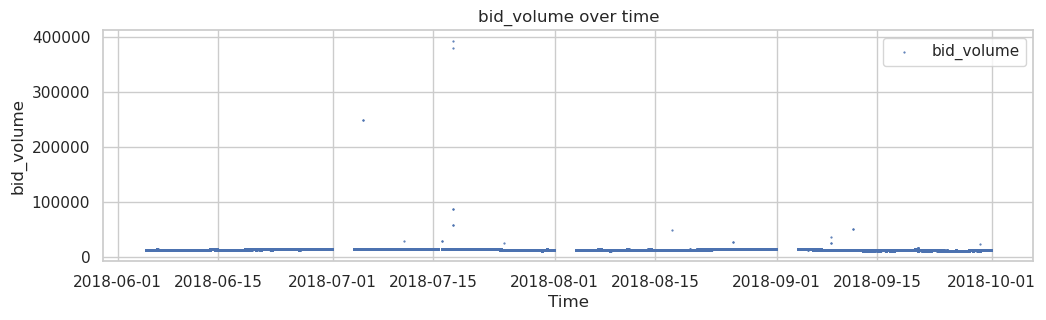

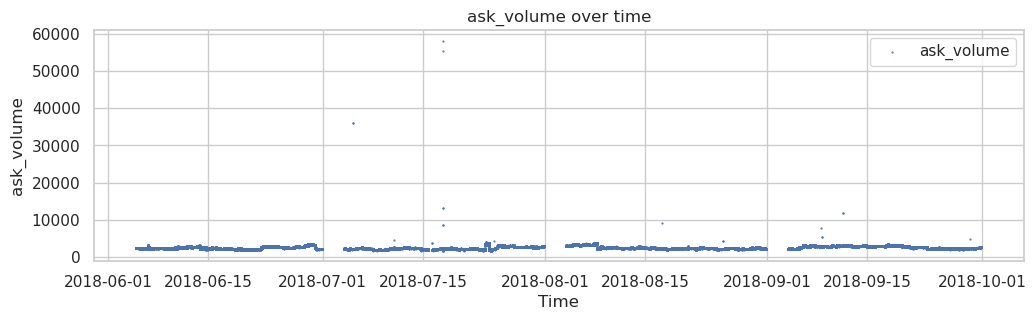

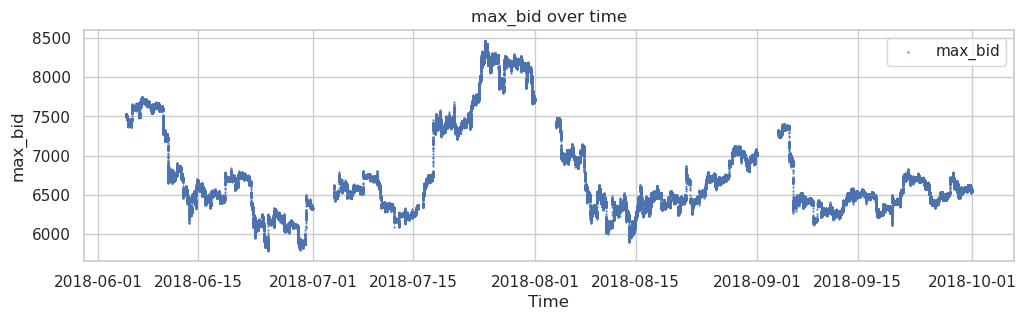

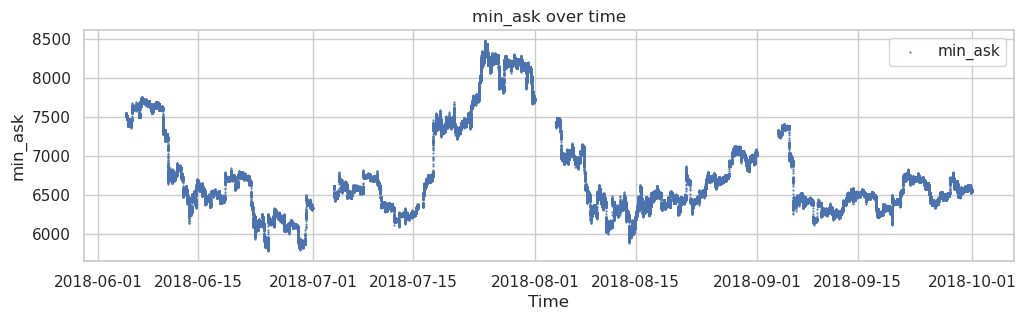

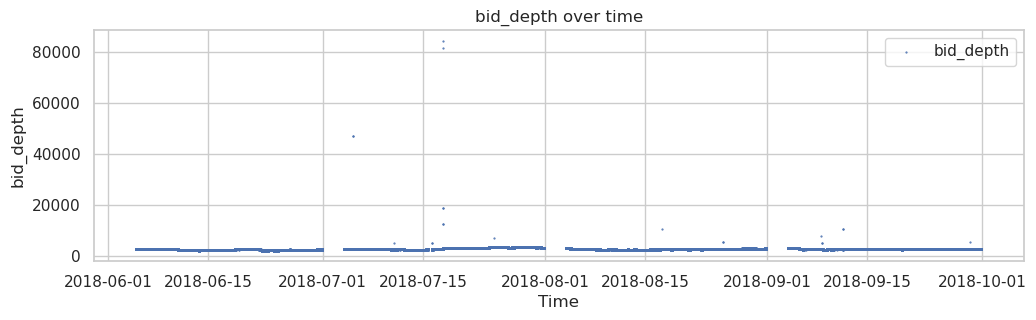

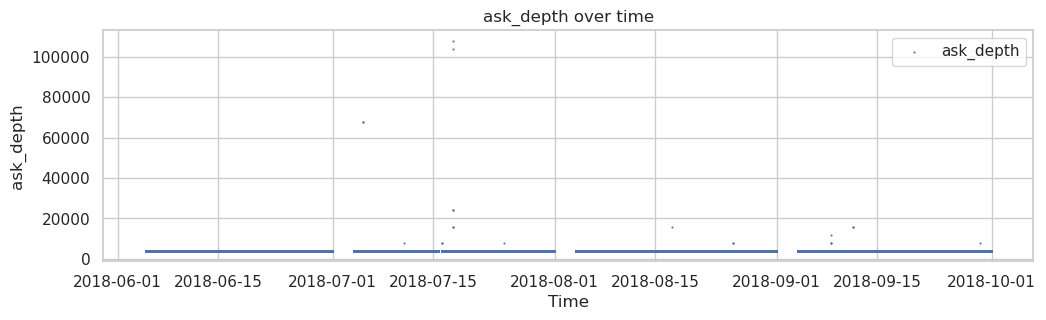

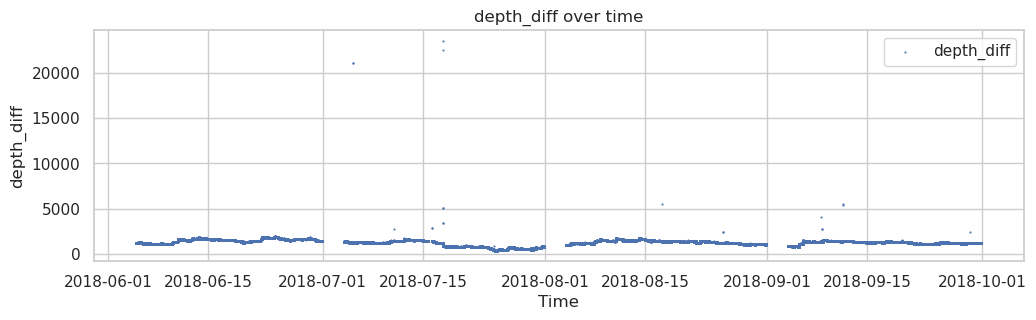

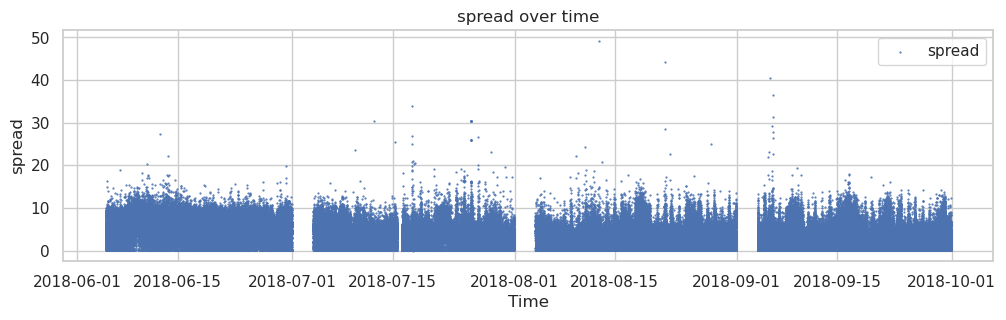

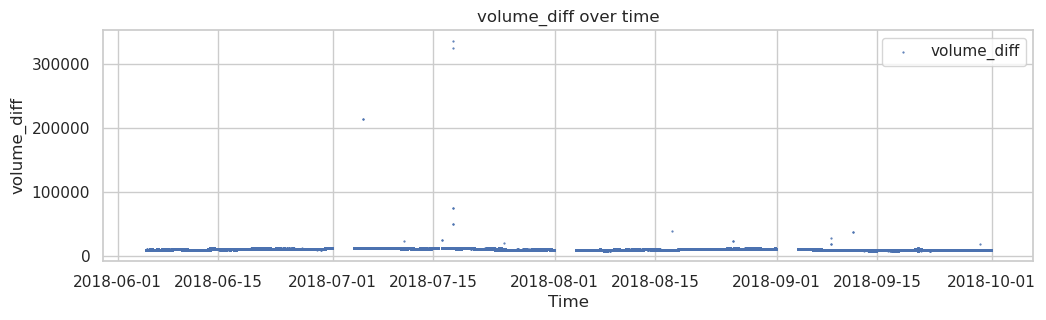

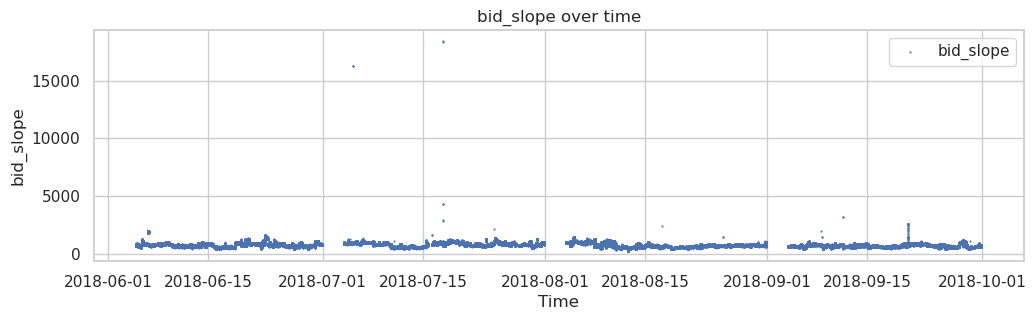

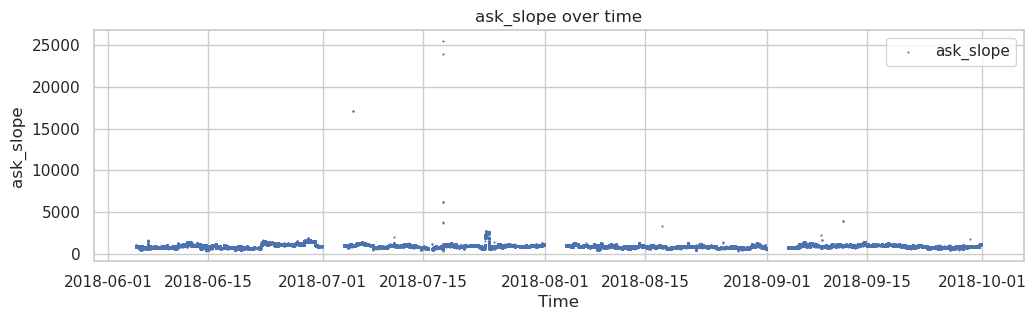

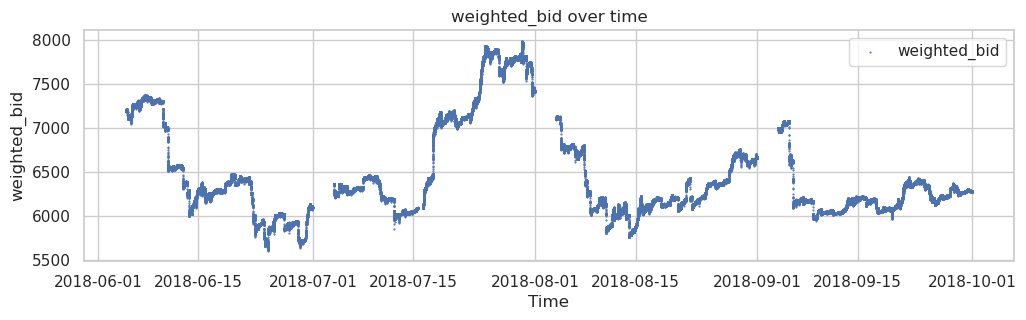

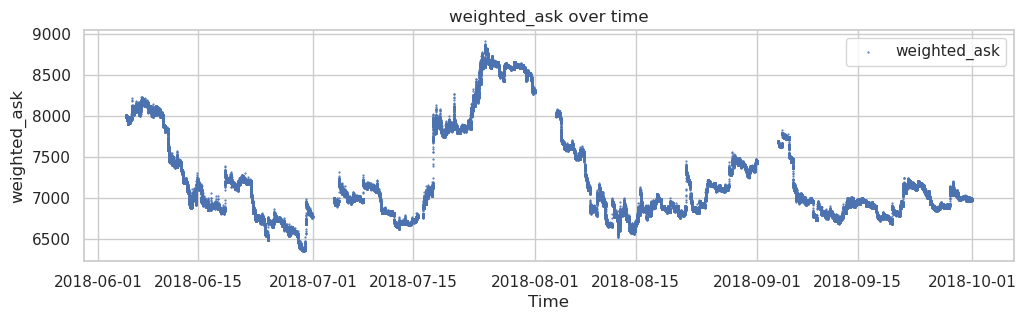

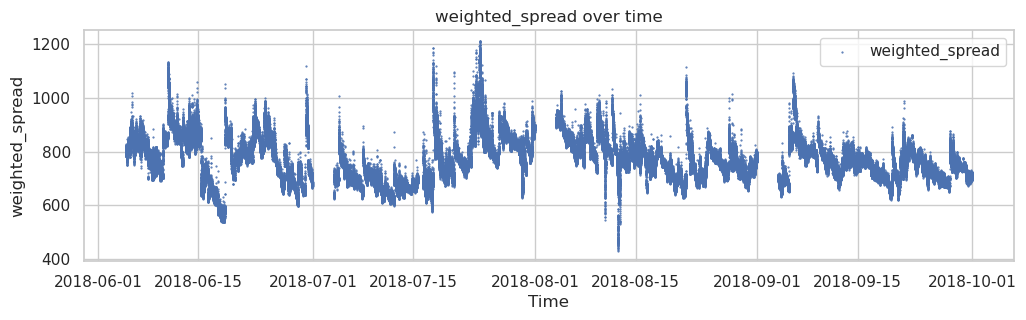

In [53]:
for feature in features.columns:
    if feature not in ["time", "bid_delta", "ask_delta"]:
        plot_feature(features, feature)

Observations:
- There are missing data for the first four days in each month, giving 3 windows of missing data.
- There are outliers in `bid_slope`, `ask_slope`, `bid_volume`, `ask_volume`, `volume_diff`, `bid_depth` and `ask_depth`, `depth_diff` features. 

## Check if Vi's features have outliers 

Let's check if the same outliers are present in Viacheslav's features (although this may not the up to date version of his features).

In [54]:
vis_features = (
    pl.read_csv(data_path / "btc" / "features.csv")
    .with_columns(pl.col("time").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("time")
)
vis_features

shape: (311_906, 11)
┌────────────┬────────┬───────────┬───────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ time       ┆ spread ┆ ask_depth ┆ bid_depth ┆ … ┆ volume_dif ┆ weighted_ ┆ ask_slope ┆ bid_slope │
│ ---        ┆ ---    ┆ ---       ┆ ---       ┆   ┆ f          ┆ spread    ┆ ---       ┆ ---       │
│ datetime[μ ┆ f64    ┆ i64       ┆ i64       ┆   ┆ ---        ┆ ---       ┆ f64       ┆ f64       │
│ s]         ┆        ┆           ┆           ┆   ┆ f64        ┆ f64       ┆           ┆           │
╞════════════╪════════╪═══════════╪═══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 2018-06-04 ┆ 6.19   ┆ 4000      ┆ 2808      ┆ … ┆ -10443.521 ┆ 1051.5787 ┆ 7581.61   ┆ 6964.01   │
│ 22:00:02   ┆        ┆           ┆           ┆   ┆ 223        ┆ 1         ┆           ┆           │
│ 2018-06-04 ┆ 6.19   ┆ 4000      ┆ 2808      ┆ … ┆ -10438.358 ┆ 1045.9153 ┆ 7581.61   ┆ 6964.01   │
│ 22:00:34   ┆        ┆           ┆           ┆   ┆ 364        ┆ 53        ┆           ┆           │
│ 2018-06-04 ┆ 4.97   ┆ 4000      ┆ 2808      ┆ … ┆ -10435.299 ┆ 1047.0826 ┆ 7581.03   ┆ 6964.01   │
│ 22:01:01   ┆        ┆           ┆           ┆   ┆ 071        ┆ 41        ┆           ┆           │
│ 2018-06-04 ┆ 4.96   ┆ 4000      ┆ 2806      ┆ … ┆ -10433.633 ┆ 1045.6313 ┆ 7587.31   ┆ 6929.32   │
│ 22:01:33   ┆        ┆           ┆           ┆   ┆ 512        ┆ 41        ┆           ┆           │
│ 2018-06-04 ┆ 4.9    ┆ 4000      ┆ 2807      ┆ … ┆ -10443.301 ┆ 1041.5024 ┆ 7587.07   ┆ 6945.0    │
│ 22:02:02   ┆        ┆           ┆           ┆   ┆ 176        ┆ 02        ┆           ┆           │
│ …          ┆ …      ┆ …         ┆ …         ┆ … ┆ …          ┆ …         ┆ …         ┆ …         │
│ 2018-09-30 ┆ 1.58   ┆ 4000      ┆ 2836      ┆ … ┆ -9303.5280 ┆ 962.44740 ┆ 6618.0    ┆ 6060.0    │
│ 21:57:34   ┆        ┆           ┆           ┆   ┆ 86         ┆ 7         ┆           ┆           │
│ 2018-09-30 ┆ 1.59   ┆ 4000      ┆ 2833      ┆ … ┆ -9312.7358 ┆ 954.26198 ┆ 6618.0    ┆ 6060.0    │
│ 21:58:01   ┆        ┆           ┆           ┆   ┆ 84         ┆ 5         ┆           ┆           │
│ 2018-09-30 ┆ 0.76   ┆ 4000      ┆ 2834      ┆ … ┆ -9305.5680 ┆ 947.09412 ┆ 6618.0    ┆ 6060.0    │
│ 21:58:34   ┆        ┆           ┆           ┆   ┆ 24         ┆ 4         ┆           ┆           │
│ 2018-09-30 ┆ 0.75   ┆ 4000      ┆ 2834      ┆ … ┆ -9276.7053 ┆ 940.77693 ┆ 6618.0    ┆ 6060.0    │
│ 21:59:01   ┆        ┆           ┆           ┆   ┆ 39         ┆ 7         ┆           ┆           │
│ 2018-09-30 ┆ 0.73   ┆ 4000      ┆ 2836      ┆ … ┆ -9293.2761 ┆ 965.74774 ┆ 6618.0    ┆ 6060.0    │
│ 21:59:33   ┆        ┆           ┆           ┆   ┆ 46         ┆ 4         ┆           ┆           │
└────────────┴────────┴───────────┴───────────┴───┴────────────┴───────────┴───────────┴───────────┘

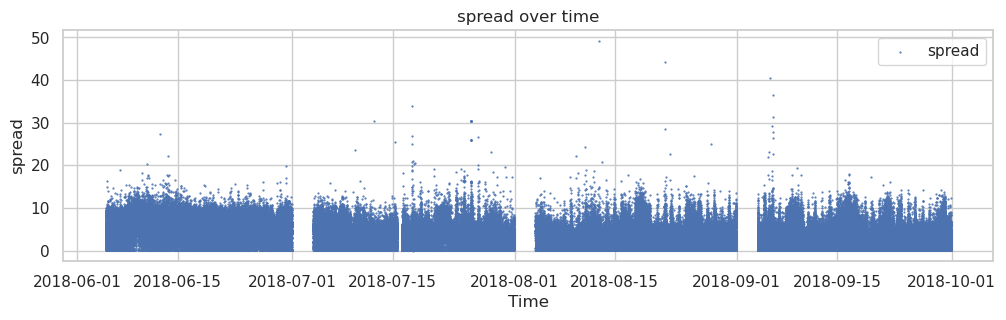

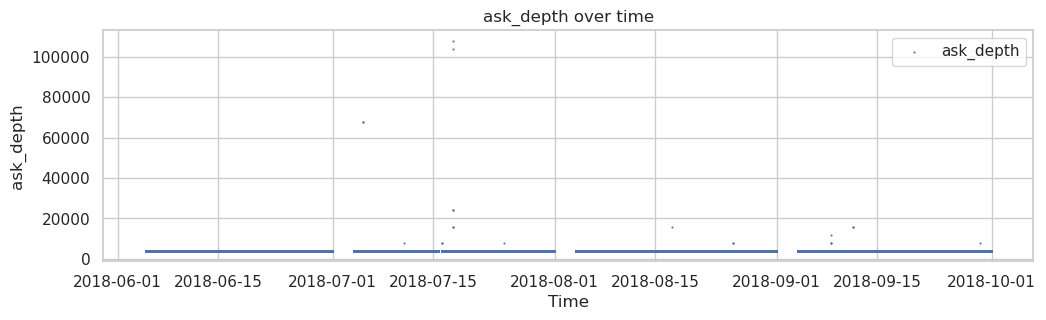

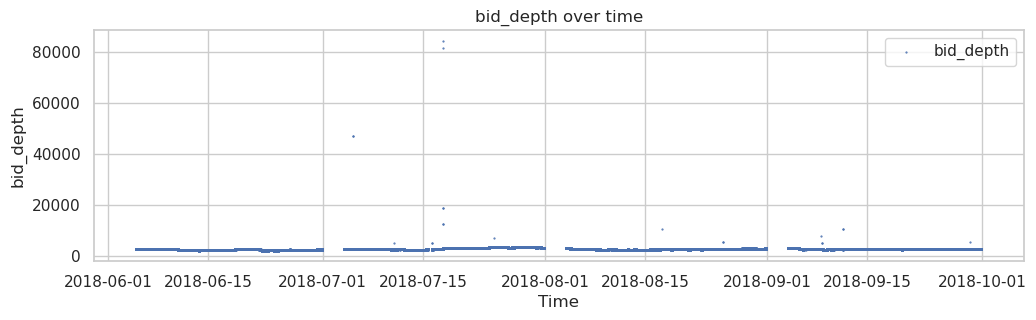

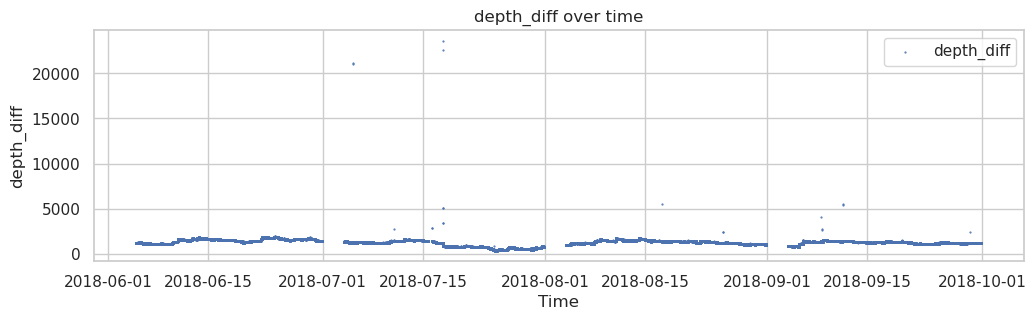

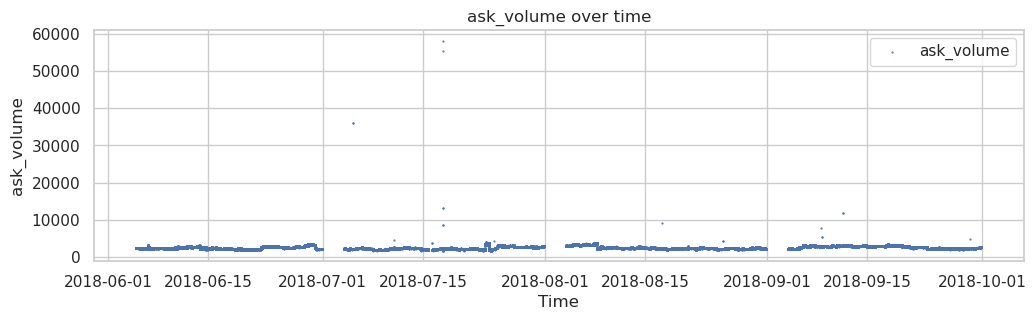

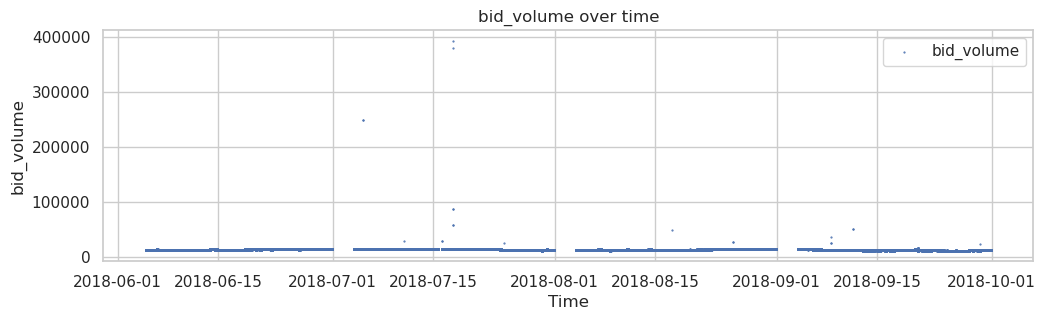

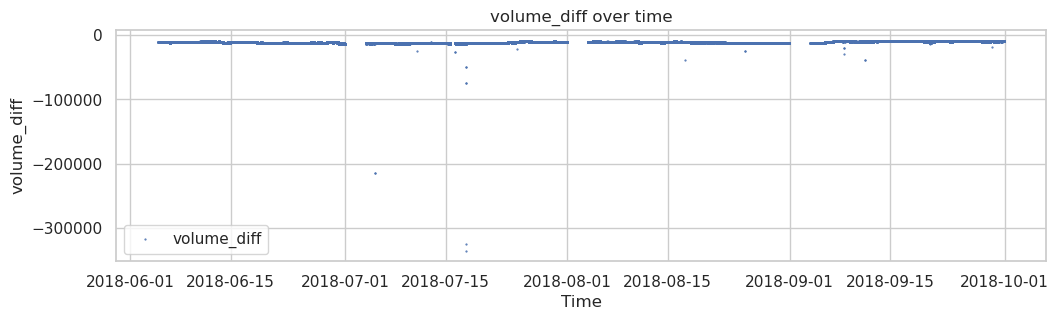

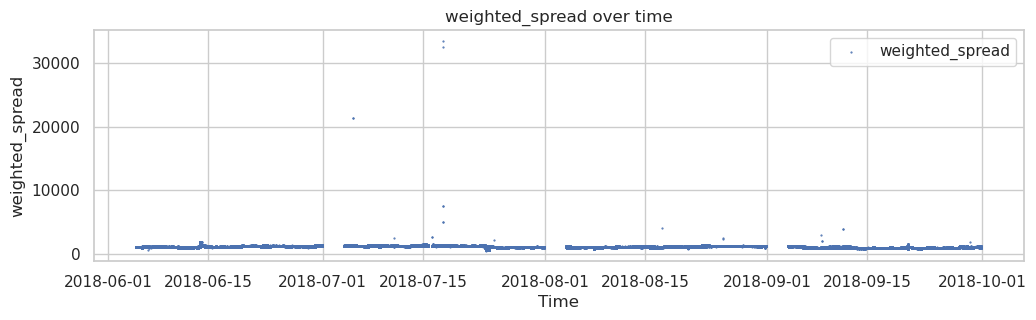

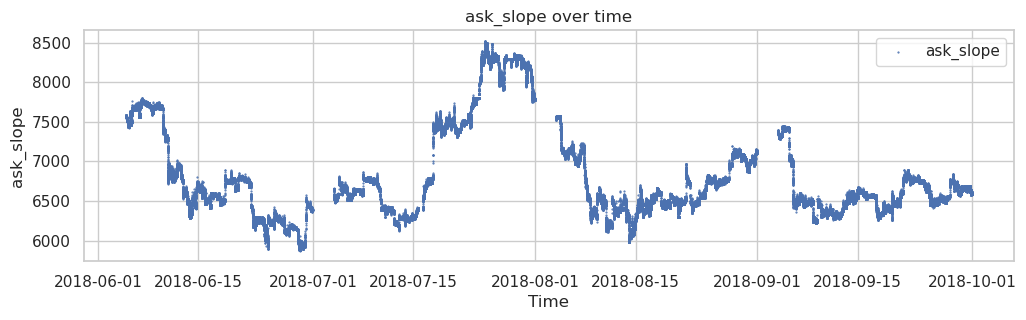

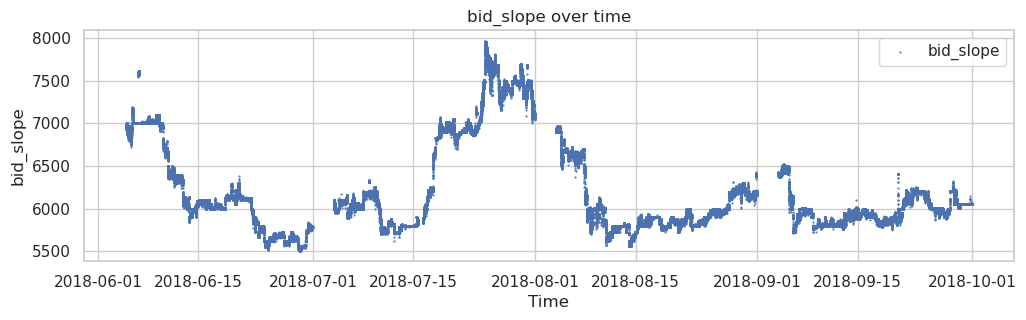

In [55]:
for feature in vis_features.columns:
    if feature not in ["time"]:
        plot_feature(vis_features, feature)

Seems like Viecheslav's features also have outliers adn the same missing data. `features.csv` is probably the old file. Look forward in this notebook, `data_df.csv` does not have these outliers.

## Filter outliers

From the above plots, it seems that the outliers are all related to the same few timestamps. We will sort the data by bid_depth or ask_depth, as these two features seem to be mostly constant over time, and the we will remove the rows with the few highest values by manually setting the threshold.

In [56]:
problematic_timestamps = []

In [57]:
problematic_timestamps.extend(
    features.filter(pl.col("bid_depth") > 5000).select("time").to_series().to_list()
)
features.sort("bid_depth", descending=True).filter(pl.col("bid_depth") > 5000).shape

(21, 15)

In [58]:
problematic_timestamps.extend(
    features.filter(pl.col("ask_depth") > 5000).select("time").to_series().to_list()
)
features.sort("ask_depth", descending=True).filter(pl.col("ask_depth") > 5000).shape

(21, 15)

In [59]:
problematic_timestamps.extend(
    features.filter(pl.col("bid_volume") > 900_000).select("time").to_series().to_list()
)
features.sort("bid_volume", descending=True).filter(
    pl.col("bid_volume") > 900_000
).shape

(0, 15)

In [60]:
problematic_timestamps.extend(
    features.filter(pl.col("ask_volume") > 8000).select("time").to_series().to_list()
)
features.sort("ask_volume", descending=True).filter(pl.col("ask_volume") > 8000).shape

(11, 15)

In [61]:
problematic_timestamps.extend(
    features.filter(pl.col("bid_slope") > 4000).select("time").to_series().to_list()
)
features.sort("bid_slope", descending=True).filter(pl.col("bid_slope") > 4000).shape

(6, 15)

In [62]:
problematic_timestamps.extend(
    features.filter(pl.col("ask_slope") > 4000).select("time").to_series().to_list()
)
features.sort("ask_slope", descending=True).filter(pl.col("ask_slope") > 4000).shape

(6, 15)

In [63]:
# union of the problematic timestamps
problematic_timestamps = list(set(problematic_timestamps))

In [64]:
len(problematic_timestamps)

21

In [65]:
# filer out the problematic timestamps
features = features.filter(~pl.col("time").is_in(problematic_timestamps))

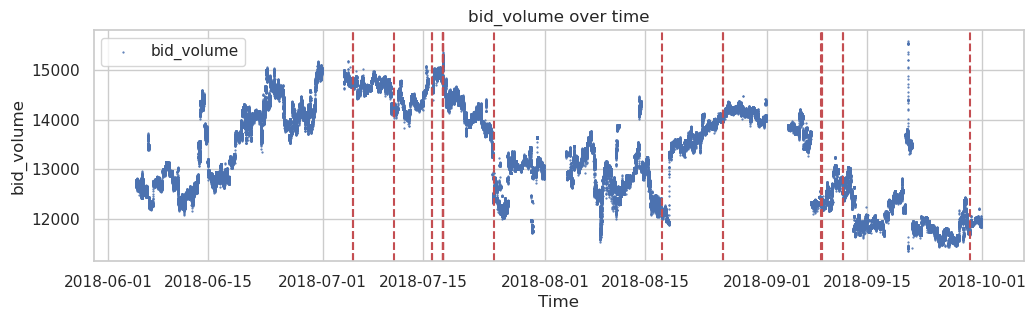

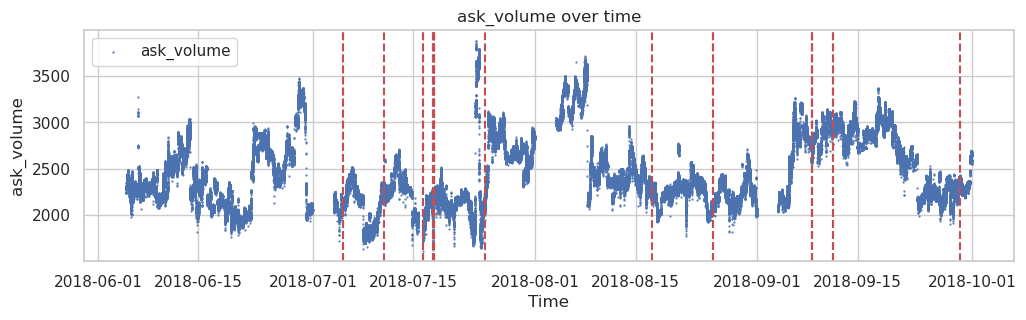

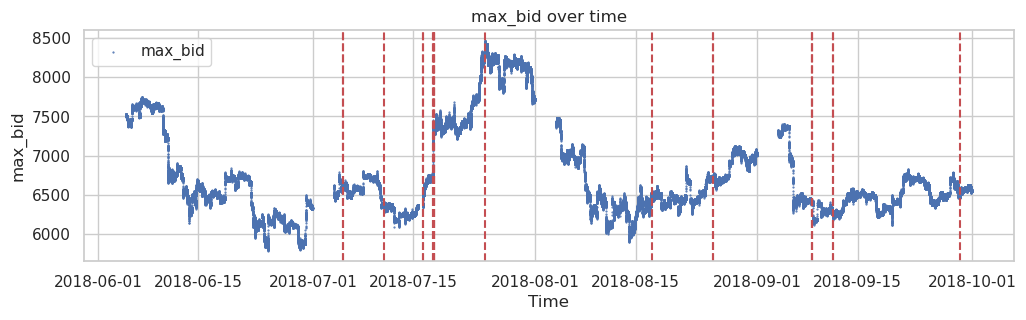

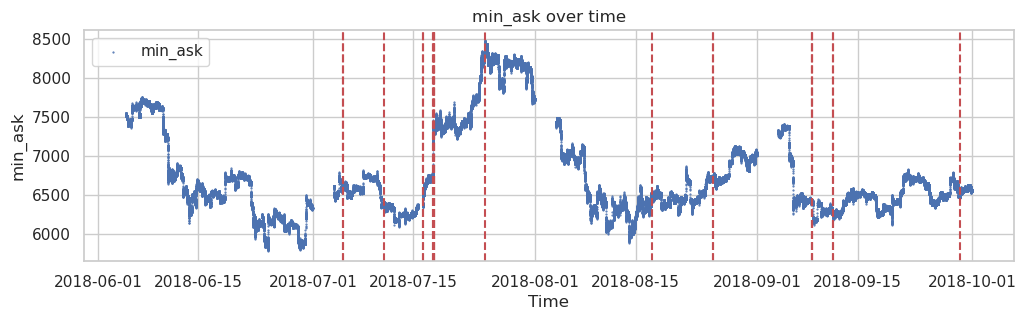

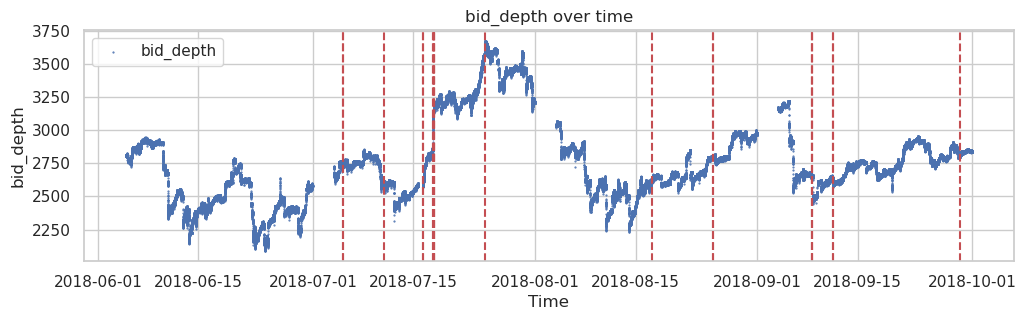

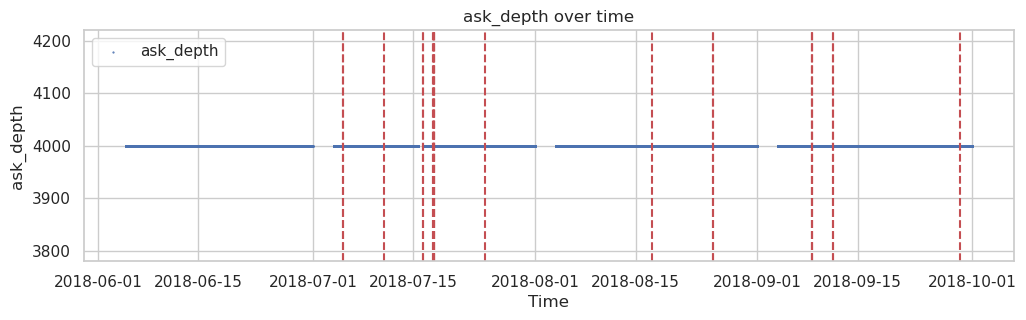

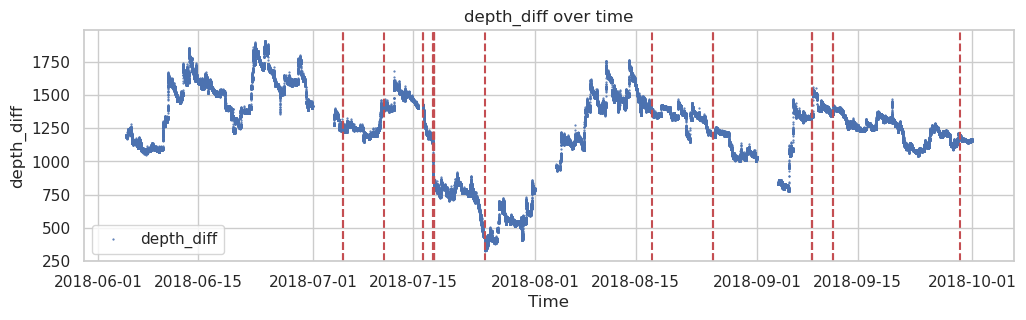

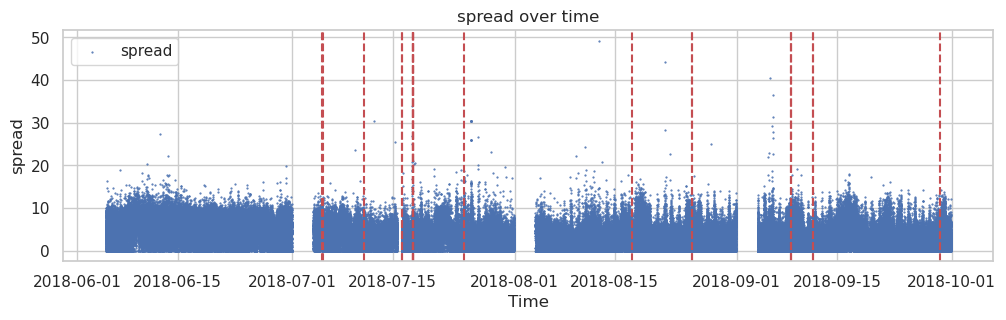

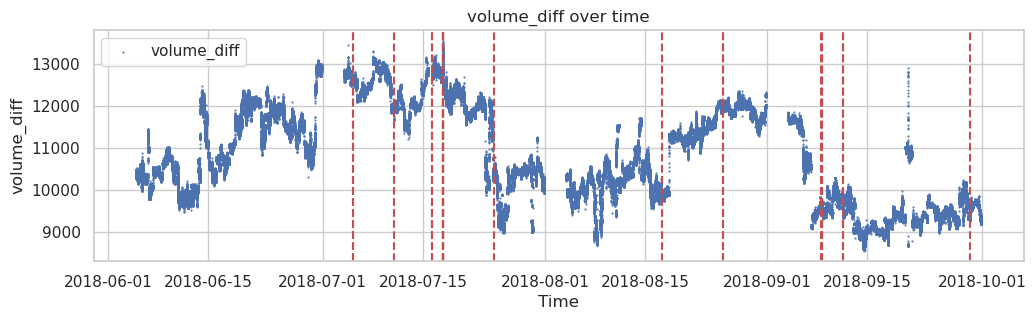

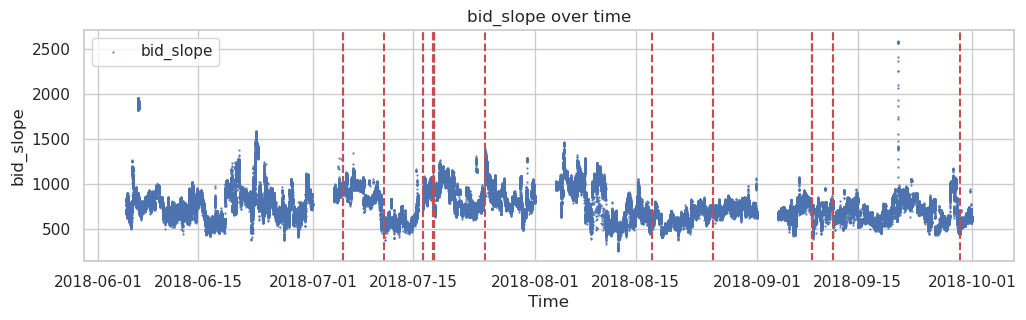

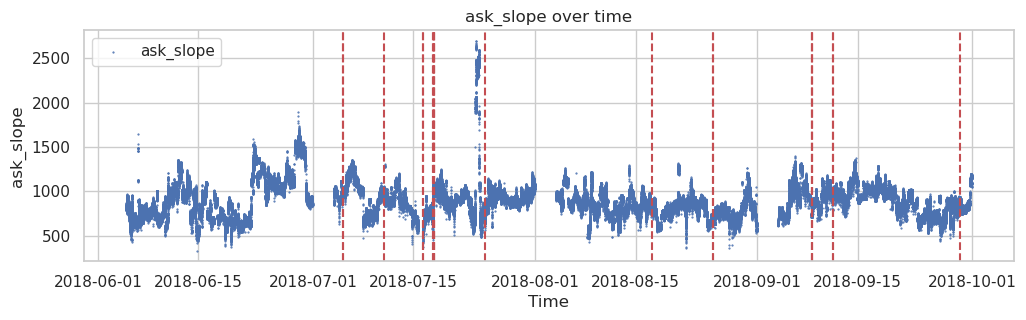

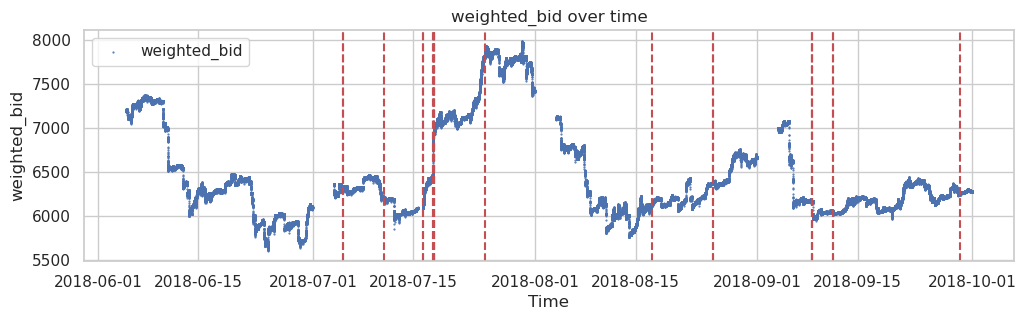

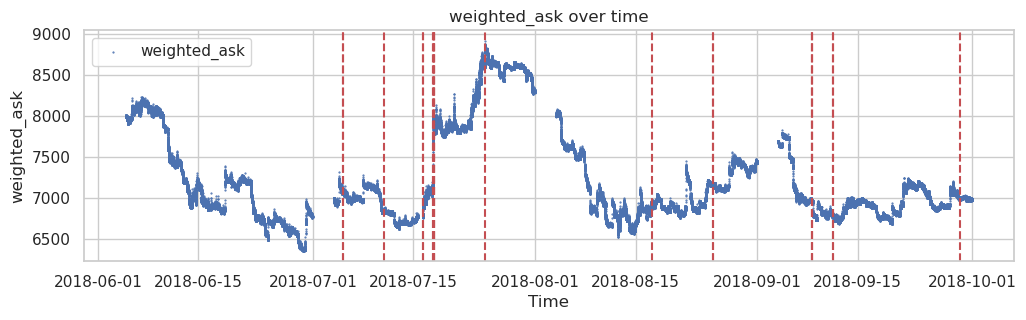

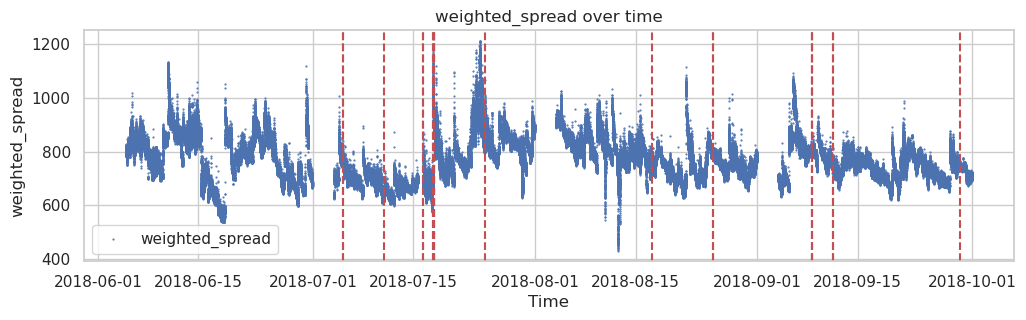

In [66]:
# plot the features again
for feature in features.columns:
    if feature not in ["time", "bid_delta", "ask_delta"]:
        plot_feature(features, feature, problematic_timestamps)

## Compare with Vi's data

Let's check if the same problem appears in the dataset preprocessed by Viecheslav's code.

In [67]:
vis_data = (
    pl.read_csv(data_path / "btc" / "data_df.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
)
vis_data

shape: (2_579, 1_215)
┌───────────┬──────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ datetime  ┆ vol      ┆ ret       ┆ ret_t-1   ┆ … ┆ volume_di ┆ weighted_ ┆ ask_slope ┆ bid_slope │
│ ---       ┆ ---      ┆ ---       ┆ ---       ┆   ┆ ff_t-120  ┆ spread_t- ┆ _t-120    ┆ _t-120    │
│ datetime[ ┆ f64      ┆ f64       ┆ f64       ┆   ┆ ---       ┆ 120       ┆ ---       ┆ ---       │
│ μs]       ┆          ┆           ┆           ┆   ┆ f64       ┆ ---       ┆ f64       ┆ f64       │
│           ┆          ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆           │
╞═══════════╪══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2018-06-0 ┆ 0.000143 ┆ -0.002229 ┆ -0.000807 ┆ … ┆ -10440.51 ┆ 1036.7256 ┆ 7548.68   ┆ 6997.83   │
│ 4         ┆          ┆           ┆           ┆   ┆ 621       ┆ 48        ┆           ┆           │
│ 23:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-06-0 ┆ 0.000115 ┆ 0.001552  ┆ -0.000217 ┆ … ┆ -10336.34 ┆ 1031.8000 ┆ 7539.55   ┆ 6937.0    │
│ 5         ┆          ┆           ┆           ┆   ┆ 9463      ┆ 62        ┆           ┆           │
│ 00:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-06-0 ┆ 0.00009  ┆ -0.001719 ┆ 0.001004  ┆ … ┆ -10441.48 ┆ 1055.5384 ┆ 7531.36   ┆ 6981.42   │
│ 5         ┆          ┆           ┆           ┆   ┆ 4297      ┆ 87        ┆           ┆           │
│ 01:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-06-0 ┆ 0.000502 ┆ -0.010899 ┆ 0.000669  ┆ … ┆ -10375.84 ┆ 1043.1412 ┆ 7520.68   ┆ 6964.01   │
│ 5         ┆          ┆           ┆           ┆   ┆ 6459      ┆ 15        ┆           ┆           │
│ 02:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-06-0 ┆ 0.000146 ┆ 0.000408  ┆ 0.000473  ┆ … ┆ -10304.46 ┆ 1032.4915 ┆ 7486.98   ┆ 6860.46   │
│ 5         ┆          ┆           ┆           ┆   ┆ 9895      ┆ 35        ┆           ┆           │
│ 03:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ …         ┆ …        ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2018-09-3 ┆ 0.000025 ┆ -0.000451 ┆ -0.00086  ┆ … ┆ -9282.363 ┆ 1051.1443 ┆ 6629.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 863       ┆ 53        ┆           ┆           │
│ 17:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-09-3 ┆ 0.000014 ┆ 0.000298  ┆ 0.000607  ┆ … ┆ -9284.887 ┆ 969.48667 ┆ 6631.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 715       ┆ 1         ┆           ┆           │
│ 18:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-09-3 ┆ 0.000024 ┆ -0.002138 ┆ -0.000023 ┆ … ┆ -9339.134 ┆ 1066.5140 ┆ 6628.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 347       ┆ 37        ┆           ┆           │
│ 19:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-09-3 ┆ 0.000089 ┆ -0.003682 ┆ -0.000012 ┆ … ┆ -9375.888 ┆ 1066.8463 ┆ 6618.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 938       ┆ 26        ┆           ┆           │
│ 20:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-09-3 ┆ 0.000034 ┆ 0.000611  ┆ -0.003663 ┆ … ┆ -9205.280 ┆ 1010.3458 ┆ 6590.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 807       ┆ 98        ┆           ┆           │
│ 21:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
└───────────┴──────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [68]:
# select columns containing 't-1' suffix in the name
keep_cols = [col for col in vis_data.columns if col.endswith("t-1")]
keep_cols.extend(["datetime", "vol"])
keep_cols

['ret_t-1',
 'spread_t-1',
 'ask_depth_t-1',
 'bid_depth_t-1',
 'depth_diff_t-1',
 'ask_volume_t-1',
 'bid_volume_t-1',
 'volume_diff_t-1',
 'weighted_spread_t-1',
 'ask_slope_t-1',
 'bid_slope_t-1',
 'datetime',
 'vol']

In [69]:
# keep only the selected columns and shift the time column by 1
vis_data = vis_data.select(keep_cols)
vis_data

shape: (2_579, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ret_t-1   ┆ spread_t- ┆ ask_depth ┆ bid_depth ┆ … ┆ ask_slope ┆ bid_slope ┆ datetime  ┆ vol      │
│ ---       ┆ 1         ┆ _t-1      ┆ _t-1      ┆   ┆ _t-1      ┆ _t-1      ┆ ---       ┆ ---      │
│ f64       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ datetime[ ┆ f64      │
│           ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ μs]       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -0.000807 ┆ 6.19      ┆ 4000.0    ┆ 2808.0    ┆ … ┆ 7581.61   ┆ 6964.01   ┆ 2018-06-0 ┆ 0.000143 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 4         ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 23:00:00  ┆          │
│ -0.000217 ┆ 4.98      ┆ 4000.0    ┆ 2809.0    ┆ … ┆ 7548.68   ┆ 6997.83   ┆ 2018-06-0 ┆ 0.000115 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 5         ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 00:00:00  ┆          │
│ 0.001004  ┆ 6.52      ┆ 4000.0    ┆ 2804.0    ┆ … ┆ 7543.39   ┆ 6942.12   ┆ 2018-06-0 ┆ 0.00009  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 5         ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 01:00:00  ┆          │
│ 0.000669  ┆ 8.22      ┆ 4000.0    ┆ 2818.0    ┆ … ┆ 7531.36   ┆ 6981.42   ┆ 2018-06-0 ┆ 0.000502 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 5         ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 02:00:00  ┆          │
│ 0.000473  ┆ 4.81      ┆ 4000.0    ┆ 2812.0    ┆ … ┆ 7520.68   ┆ 6964.01   ┆ 2018-06-0 ┆ 0.000146 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 5         ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 03:00:00  ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ -0.00086  ┆ 2.51      ┆ 4000.0    ┆ 2837.0    ┆ … ┆ 6618.0    ┆ 6060.0    ┆ 2018-09-3 ┆ 0.000025 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 0         ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 17:00:00  ┆          │
│ 0.000607  ┆ 0.08      ┆ 4000.0    ┆ 2841.0    ┆ … ┆ 6629.0    ┆ 6060.0    ┆ 2018-09-3 ┆ 0.000014 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 0         ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 18:00:00  ┆          │
│ -0.000023 ┆ 3.11      ┆ 4000.0    ┆ 2844.0    ┆ … ┆ 6631.0    ┆ 6060.0    ┆ 2018-09-3 ┆ 0.000024 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 0         ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 19:00:00  ┆          │
│ -0.000012 ┆ 3.89      ┆ 4000.0    ┆ 2841.0    ┆ … ┆ 6628.0    ┆ 6060.0    ┆ 2018-09-3 ┆ 0.000089 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 0         ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 20:00:00  ┆          │
│ -0.003663 ┆ 0.99      ┆ 4000.0    ┆ 2844.0    ┆ … ┆ 6618.0    ┆ 6060.0    ┆ 2018-09-3 ┆ 0.000034 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 0         ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ 21:00:00  ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

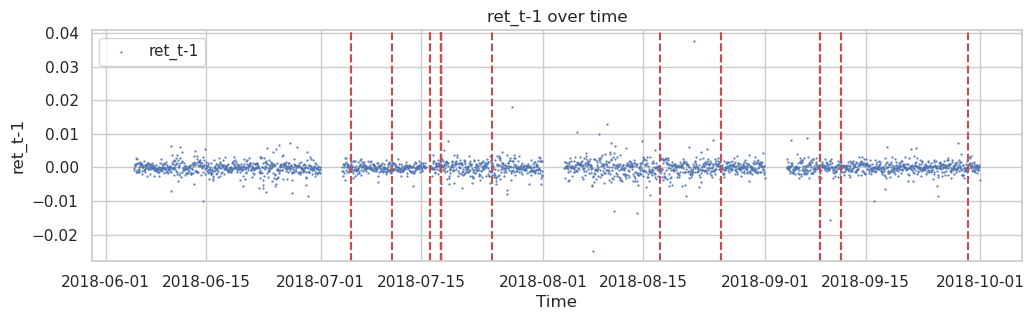

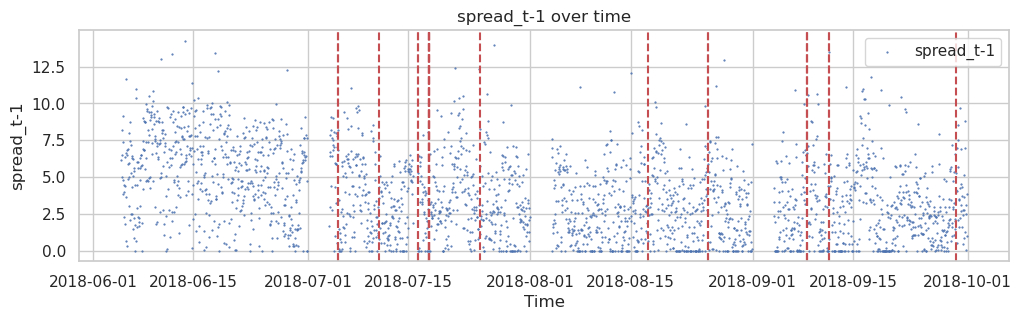

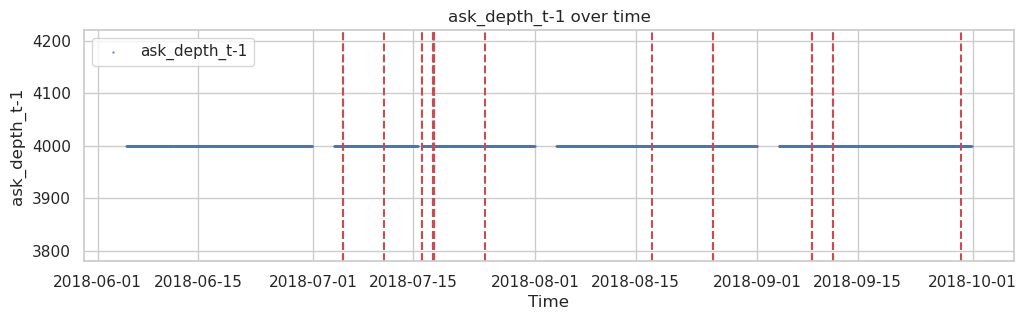

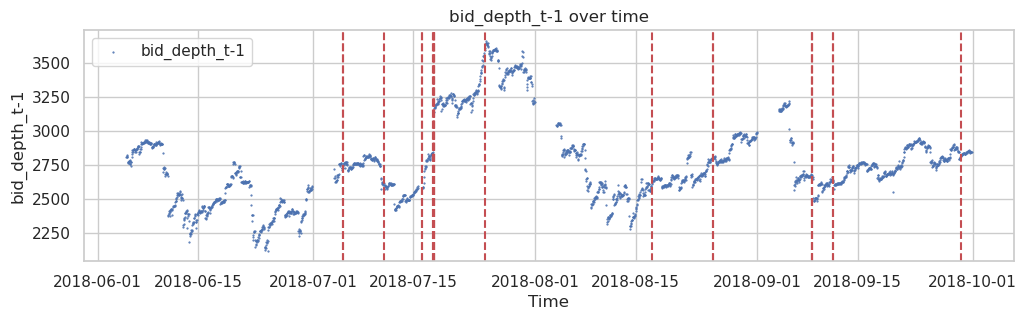

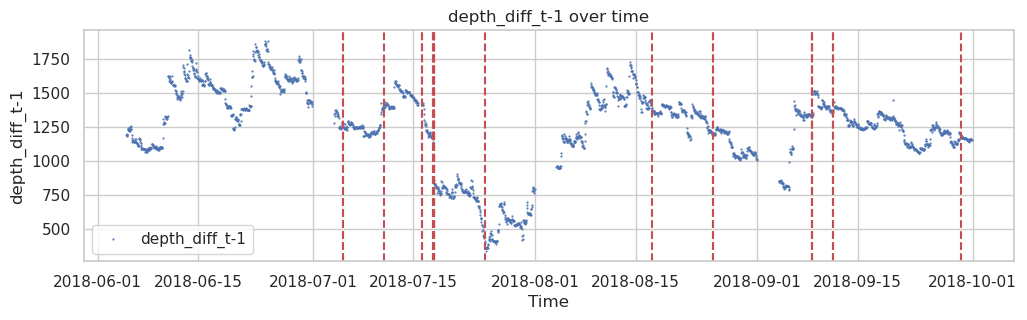

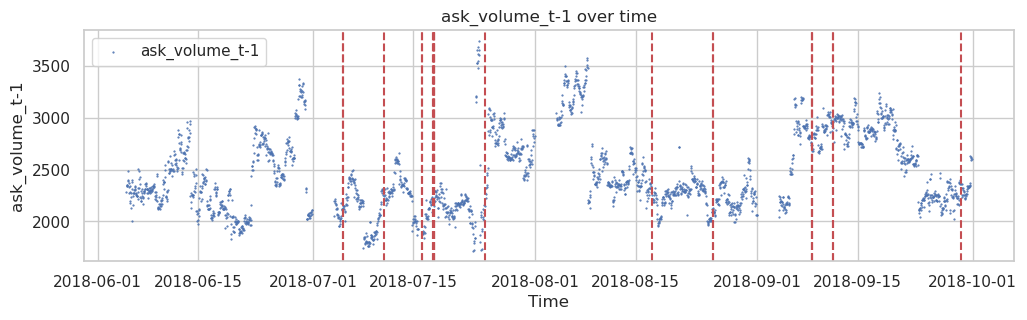

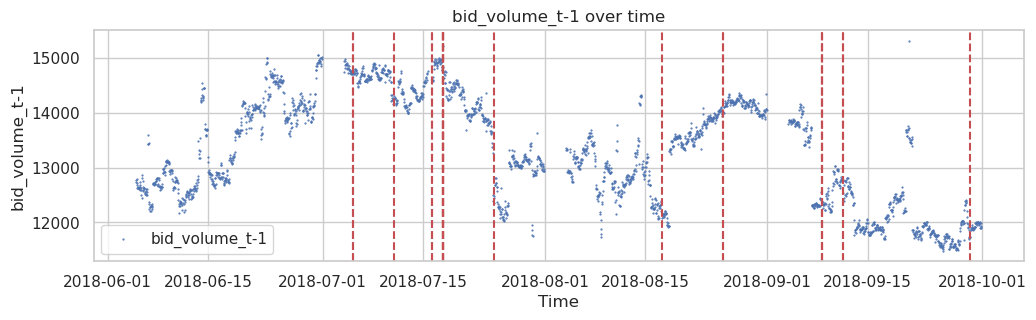

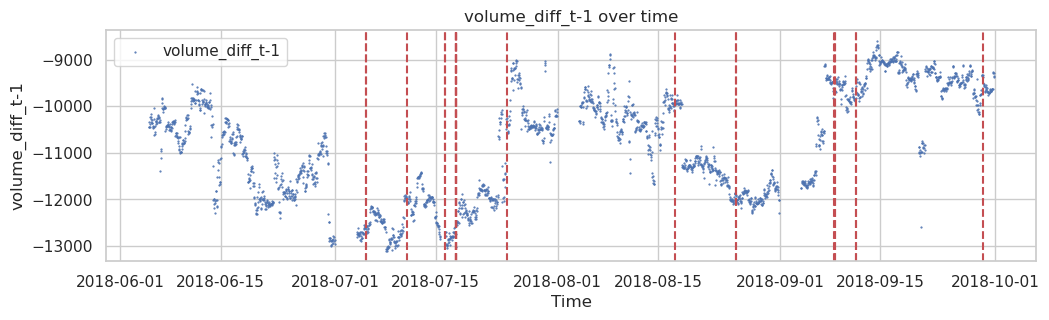

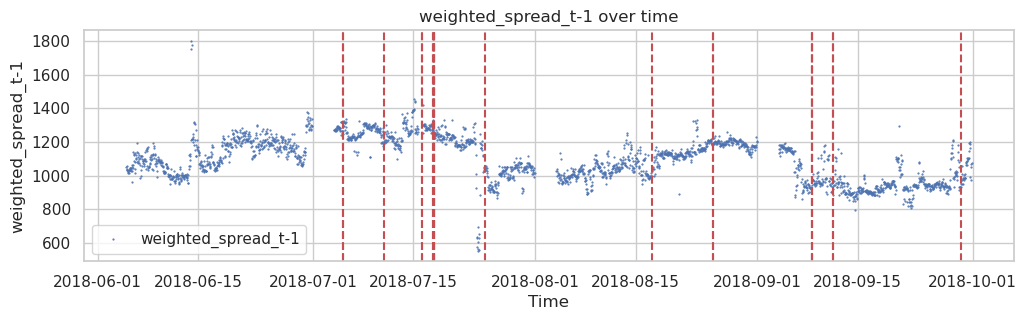

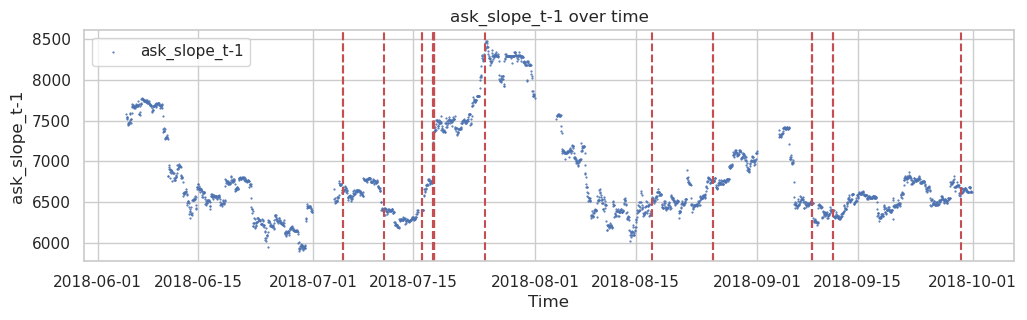

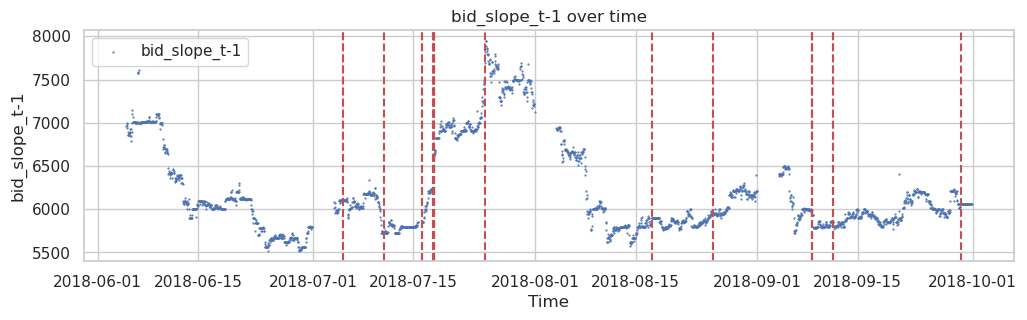

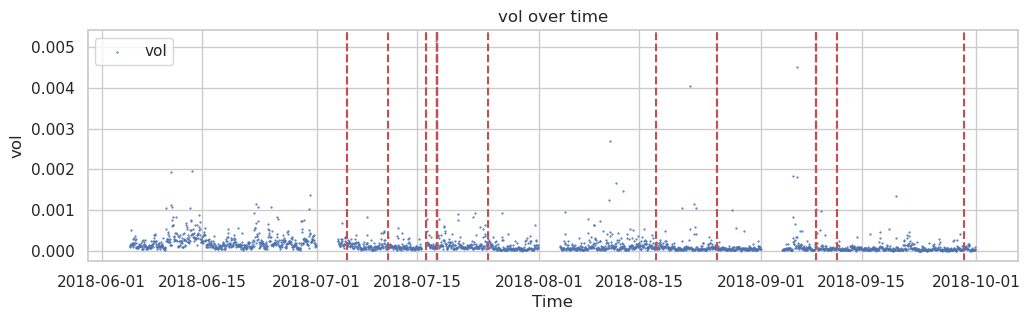

In [70]:
# plot vis_data


def plot_vis_data(df, feature, problematic_timestamps=None):
    plt.figure(figsize=(12, 3))
    plt.scatter(df["datetime"], df[feature], label=feature, alpha=1, s=0.3)
    plt.title(f"{feature} over time")
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.legend()
    if problematic_timestamps is not None:
        for timestamp in problematic_timestamps:
            plt.axvline(
                x=timestamp, color="r", linestyle="--", label="Problematic Timestamp"
            )
    plt.show()


for feature in vis_data.columns:
    if feature != "datetime":
        plot_vis_data(vis_data, feature, problematic_timestamps)

In [71]:
# plot vis_features and features together
def plot_vis_features_and_features(df1, df2, feature, problematic_timestamps=None):
    plt.figure(figsize=(12, 3))
    plt.scatter(
        df1["datetime"], df1[feature + "_t-1"], label=feature + " (Vi)", alpha=1, s=0.3
    )
    plt.scatter(df2["time"], df2[feature], label=feature + " (Miro)", alpha=0.1, s=0.3)
    plt.title(f"{feature}")
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.legend()
    if problematic_timestamps is not None:
        for timestamp in problematic_timestamps:
            plt.axvline(
                x=timestamp, color="r", linestyle="--", label="Problematic Timestamp"
            )
    plt.show()

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


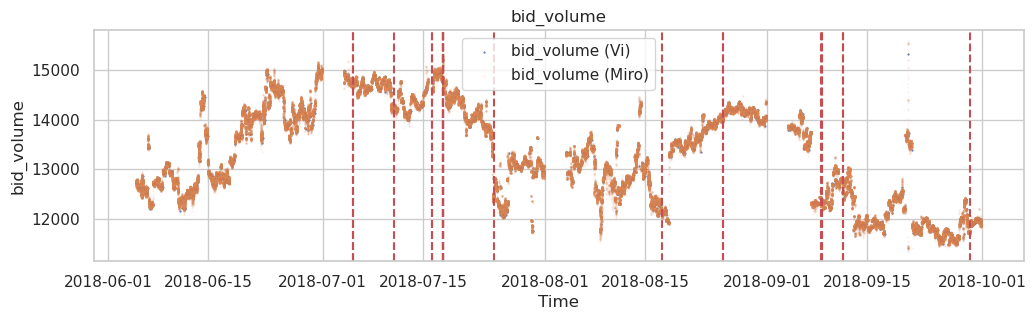

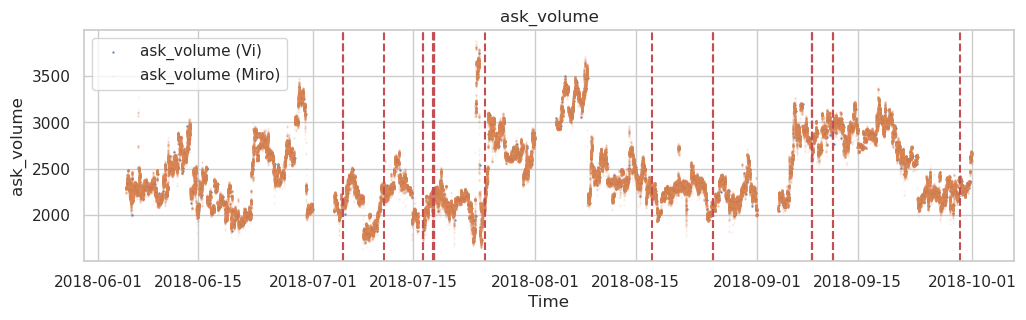

Error plotting max_bid: "max_bid_t-1" not found
Error plotting min_ask: "min_ask_t-1" not found


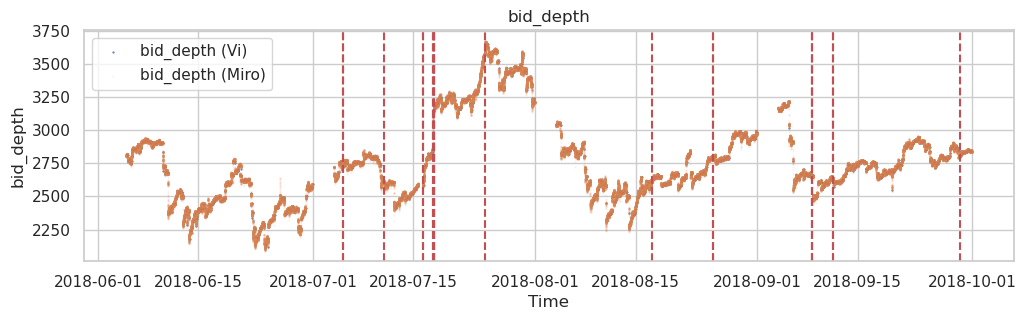

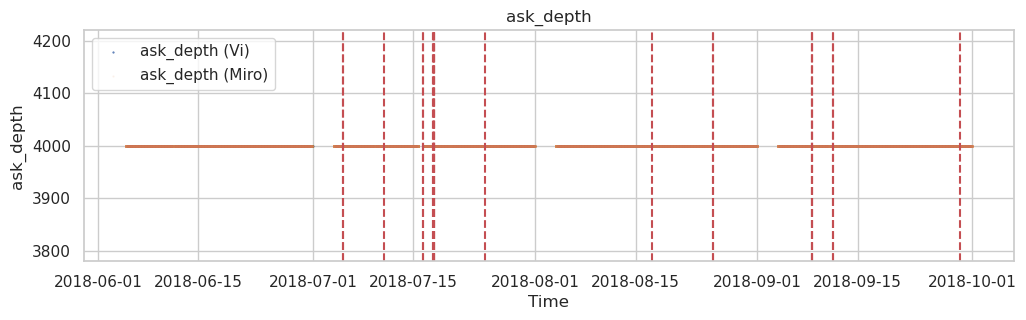

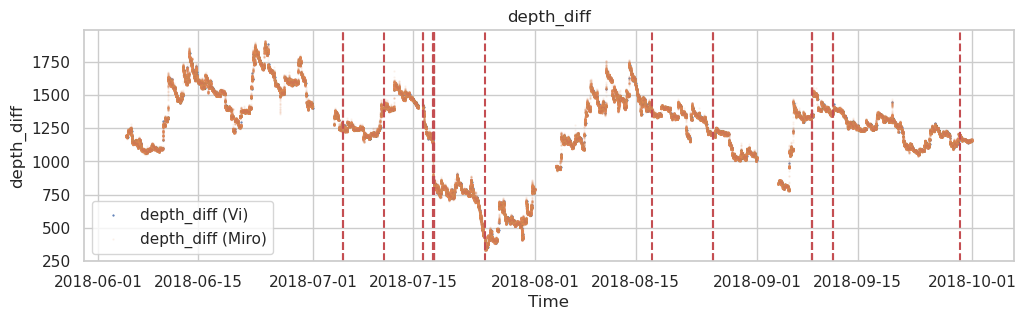

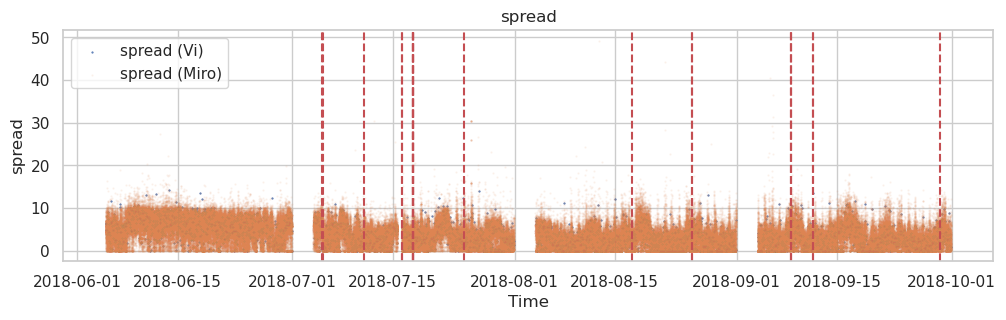

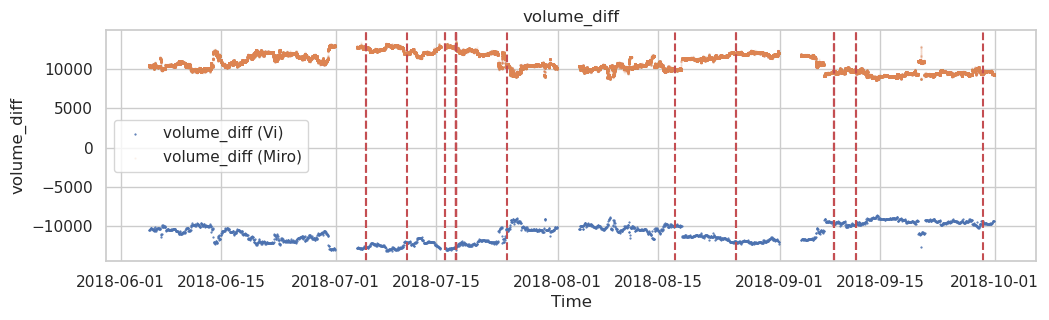

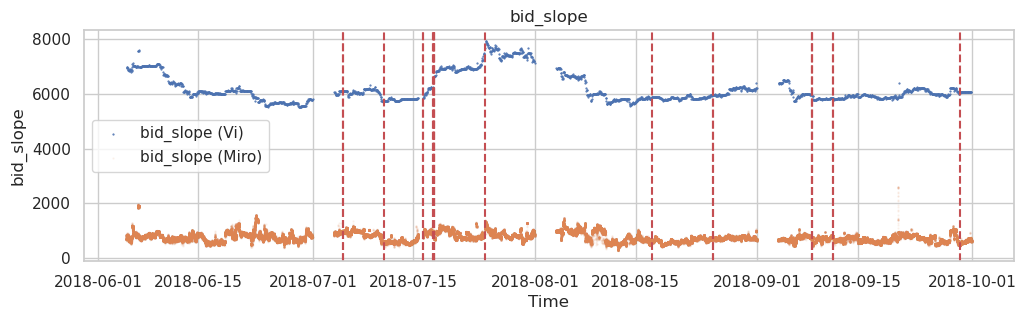

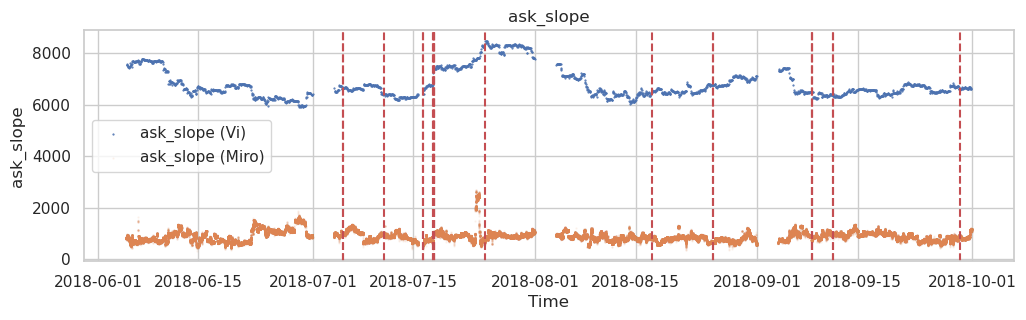

Error plotting weighted_bid: "weighted_bid_t-1" not found
Error plotting weighted_ask: "weighted_ask_t-1" not found


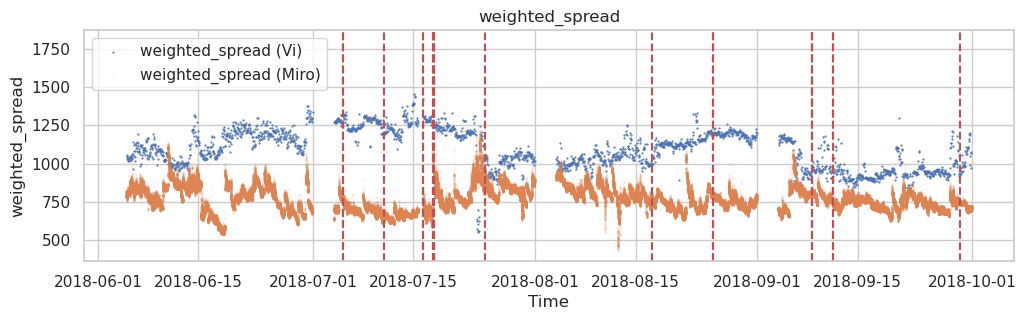

In [72]:
for feature in features.columns:
    if feature not in ["time"]:
        try:
            plot_vis_features_and_features(
                vis_data, features, feature, problematic_timestamps
            )
        except Exception as e:
            print(f"Error plotting {feature}: {e}")
            plt.close()

## Conclusions
- The outliers are not present in `data_df.csv` preprocessed by Viecheslav's code.
- Some features, like `weighted_spread`, `ask_slope`, `bid_slope` differ significantly in the methods of calculation (Miroslav's vs Viecheslav's).
- Other features are very similar, up to multiplication or additive constant.

# Trade data

Here we inspect raw trade data and we compare two methods of computing the target variable (volatility).

## Load and format

In [73]:
csv_files = list(raw_data_path.glob("bitstamp_trx*.zip"))

In [74]:
csv_files[:5]

[PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_trx_10_09_2018.zip'),
 PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_trx_16_07_2018.zip'),
 PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_trx_21_06_2018.zip'),
 PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_trx_31_08_2018.zip'),
 PosixPath('/home/miroslav/Documents/projects/mlfcs/data/raw/bitstamp_trx_16_08_2018.zip')]

In [75]:
dataframes = []

for csv_file in tqdm(csv_files, desc="Processing CSV files"):
    # load and format
    trx_sample = pd.read_csv(csv_file)

    # fix column names by removing spaces and quotes
    trx_sample.columns = [
        s.replace(" ", "").replace("'", "") for s in trx_sample.columns
    ]

    # 'datetime' columns to datetime type
    # trx_sample["datetime"] = pd.to_datetime(trx_sample["datetime"])

    dataframes.append(trx_sample)

df = pd.concat(dataframes, ignore_index=True)

Processing CSV files: 100%|██████████| 122/122 [00:09<00:00, 12.58it/s]


In [76]:
df["datetime"] = pd.to_datetime(df["datetime"])
# re,move timezone information if exists
df["datetime"] = df["datetime"].dt.tz_localize(None)
df = df.set_index("datetime")
df.sort_index()

timestamp    price         cost        id  \
datetime                                                             
2018-05-31 21:00:13  1527800413000  7538.34    75.383400  67405327   
2018-05-31 21:00:18  1527800418000  7533.92    35.761333  67405331   
2018-05-31 21:00:18  1527800418000  7535.44  2995.337400  67405330   
2018-05-31 21:00:18  1527800418000  7536.00     7.536000  67405329   
2018-05-31 21:00:18  1527800418000  7537.49   753.749000  67405328   
...                            ...      ...          ...       ...   
2018-09-30 21:59:37  1538344777000  6555.78   280.549950  75177318   
2018-09-30 21:59:37  1538344777000  6555.77  1216.049379  75177317   
2018-09-30 21:59:37  1538344777000  6555.76  1497.396225  75177316   
2018-09-30 21:59:37  1538344777000  6555.75  1349.606357  75177315   
2018-09-30 21:59:37  1538344777000  6555.74  1106.925030  75177314   

                                      fee            fee1  order    symbol  \
datetime                                                                     
2018-05-31 21:00:13   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-05-31 21:00:18   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-05-31 21:00:18   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-05-31 21:00:18   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-05-31 21:00:18   {'currency': u'USD'   'cost': None}   None   BTC/USD   
...                                   ...             ...    ...       ...   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   

                       amount   type   side  
datetime                                     
2018-05-31 21:00:13  0.010000   None   sell  
2018-05-31 21:00:18  0.004747   None   sell  
2018-05-31 21:00:18  0.397500   None   sell  
2018-05-31 21:00:18  0.001000   None   sell  
2018-05-31 21:00:18  0.100000   None   sell  
...                       ...    ...    ...  
2018-09-30 21:59:37  0.042794   None    buy  
2018-09-30 21:59:37  0.185493   None    buy  
2018-09-30 21:59:37  0.228409   None    buy  
2018-09-30 21:59:37  0.205866   None    buy  
2018-09-30 21:59:37  0.168848   None    buy  

[2795142 rows x 11 columns]

## Inspect computation of volatility

Input to both methods of computing volatility and returns are individual trades. These trades occur in 30s intervals labeled by `timestamp` column. Each trade has `price` and `amount` of bitcoin traded. We can compute the returns and volatility in two different ways.

Vi's method of computing volatility and returns:

In [77]:
returns = df["price"].sort_index().pct_change()
returns = returns.dropna()
vol = (returns**2).resample("h").sum().rename("vol")
ret = returns.add(1).resample("h").prod().add(-1).rename("ret")
hourly = pd.merge(vol, ret, left_index=True, right_index=True, how="outer")

Alternatively, we can first average all trade prices in each 30s interval to obtain a single price for each interval. Then, we can compute the returns and volatility using these average prices:

In [78]:
price2 = df["price"].sort_index()
mean_price2 = df["price"].groupby(price2.index).mean()
returns2 = mean_price2.sort_index().pct_change()
returns2 = returns2.dropna()
vol2 = (returns2**2).resample("h").sum().rename("vol")
ret2 = returns2.add(1).resample("h").prod().add(-1).rename("ret")

Let's now compare the results.

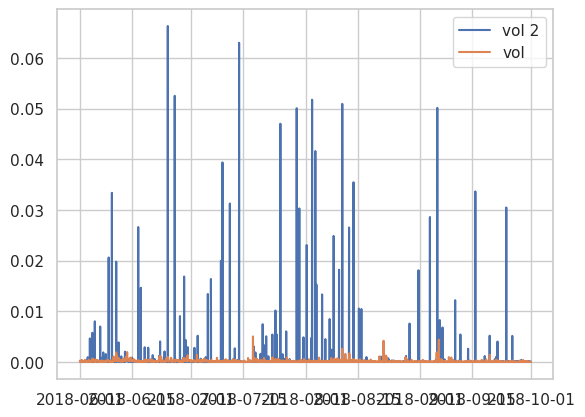

In [79]:
plt.plot(vol2, label="vol 2")
plt.plot(vol, label="vol")
plt.legend()

# plt.xlim([vol.index[300], vol.index[450]])

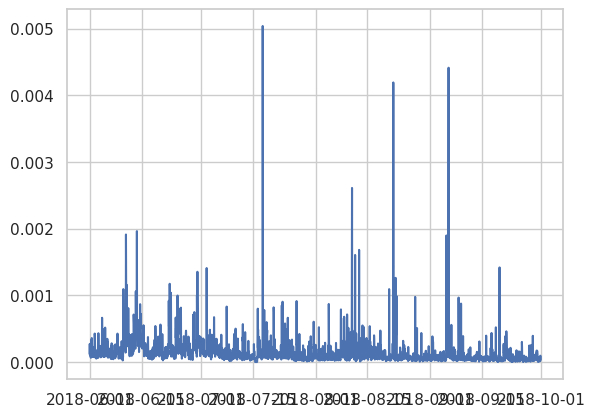

In [80]:
plt.plot(vol, label="vol")

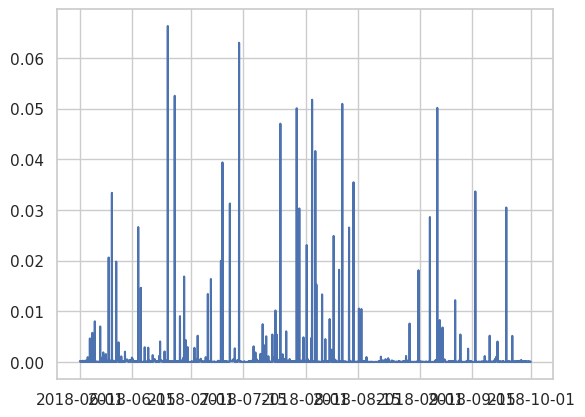

In [81]:
plt.plot(vol2, label="vol2")

In [82]:
rel_diff = (vol - vol2) / vol

(array([1.00e+00, 0.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        3.00e+00, 4.00e+00, 1.40e+01, 2.89e+03]),
 array([-1.23516714e+03, -1.11155209e+03, -9.87937046e+02, -8.64322001e+02,
        -7.40706955e+02, -6.17091909e+02, -4.93476863e+02, -3.69861818e+02,
        -2.46246772e+02, -1.22631726e+02,  9.83319543e-01]),
 <BarContainer object of 10 artists>)

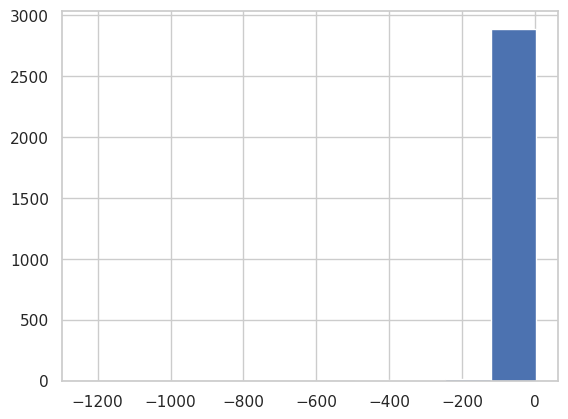

In [83]:
plt.hist(rel_diff.values, label="(vol - vol2) / vol")

In [84]:
corr = vol.corr(vol2)

In [85]:
corr

0.09916700573179325

In [86]:
rel_diff.corr(vol)

0.02321876184931665

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log(vol2)')

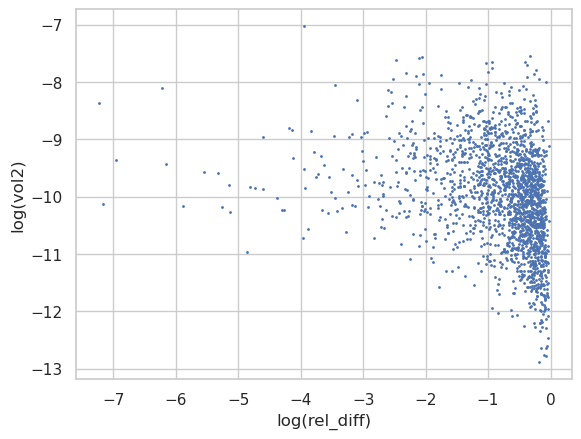

In [87]:
plt.scatter(np.log(rel_diff), np.log(vol2), s=1)
plt.xlabel("log(rel_diff)")
plt.ylabel("log(vol2)")

In the option pricing literature the realized volatility is usually defined as standard deviation of log returns. On the small time scale of 30s relative returns (`pd.DataFrame.pct_change()` is not in percentages). Keep this in mind when comparing to the literature and when interpreting the results.

In [88]:
logreturns = df["price"].sort_index().apply(lambda x: np.log(x)).pct_change().dropna()
rv = (logreturns**2).resample("h").sum().rename("vol")
# ret2 = logreturns.add(1).resample("h").prod().add(-1).rename("ret")

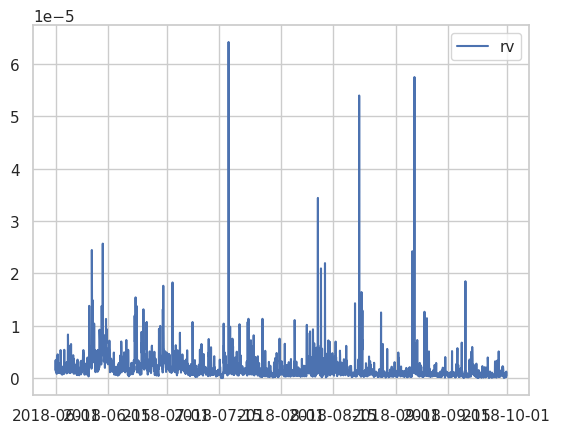

In [89]:
plt.plot(rv, label="rv")
plt.legend()

## Conclusions

- `(returns**2).resample("h").sum()` computes the volatility as quadratic variation of raw prices - not log prices.
- We will keep the Vi's method for computing volatility and returns, as it is more informative of high-frequency movements in the price. One should be aware of this dynamics when modeling this kind of volatility as there is probably more non-linear relationship between past volatility and the forecasted volatility in this context compared to the usually method of computing volatility without high-frequency trades.




# Inspect missing data in merged data


In [90]:
from datetime import datetime

In [91]:
full_data = (
    pl.read_csv(data_path / "btc" / "data_df.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
)

(0.0, 0.003)

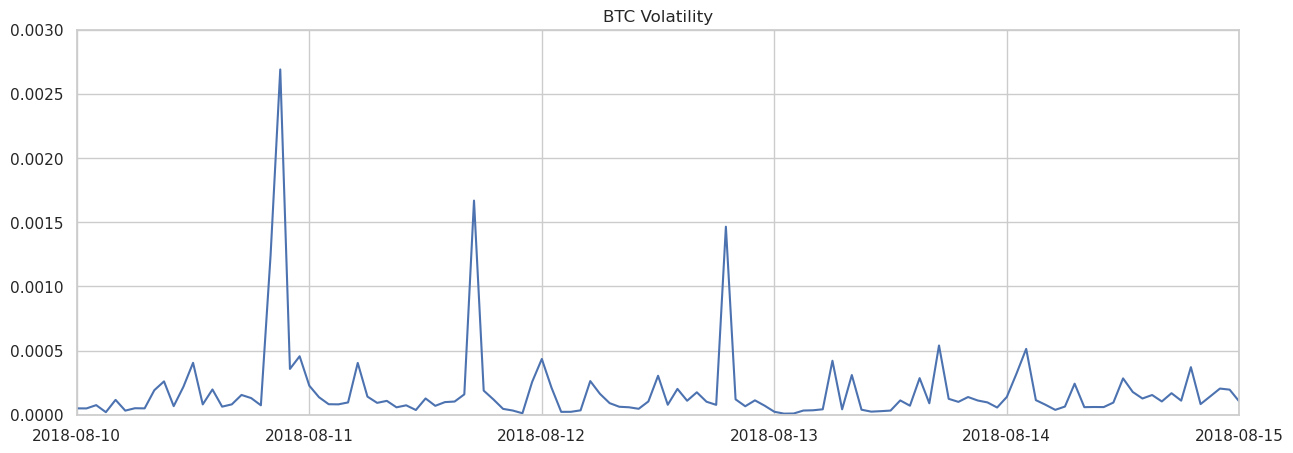

In [92]:
plt.figure(figsize=(15, 5))
plt.plot(full_data.to_pandas().set_index("datetime").loc[:, "vol"])
plt.title("BTC Volatility")
plt.xlim(
    datetime.strptime("2018-08-10", "%Y-%m-%d"),
    datetime.strptime("2018-08-15", "%Y-%m-%d"),
)
plt.ylim(0, 0.003)

In [93]:
full_data.to_pandas().set_index("datetime").index.is_monotonic_increasing

True

In [94]:
# where are the gaps?
full_vola_ser = full_data.to_pandas().set_index("datetime").loc[:, "vol"]
full_vola_ser

datetime
2018-06-04 23:00:00    0.000143
2018-06-05 00:00:00    0.000115
2018-06-05 01:00:00    0.000090
2018-06-05 02:00:00    0.000502
2018-06-05 03:00:00    0.000146
                         ...   
2018-09-30 17:00:00    0.000025
2018-09-30 18:00:00    0.000014
2018-09-30 19:00:00    0.000024
2018-09-30 20:00:00    0.000089
2018-09-30 21:00:00    0.000034
Name: vol, Length: 2579, dtype: float64

In [95]:
timestamps = pd.date_range(
    start=full_vola_ser.index.min(), end=full_vola_ser.index.max(), freq="h"
)
timestamps = pd.Series(timestamps)
missing_timestamps = timestamps[timestamps.isin(full_vola_ser.index) == False]
missing_timestamps

157    2018-06-11 12:00:00
158    2018-06-11 13:00:00
619    2018-06-30 18:00:00
624    2018-06-30 23:00:00
625    2018-07-01 00:00:00
               ...        
2306   2018-09-09 01:00:00
2352   2018-09-10 23:00:00
2368   2018-09-11 15:00:00
2455   2018-09-15 06:00:00
2793   2018-09-29 08:00:00
Length: 252, dtype: datetime64[ns]

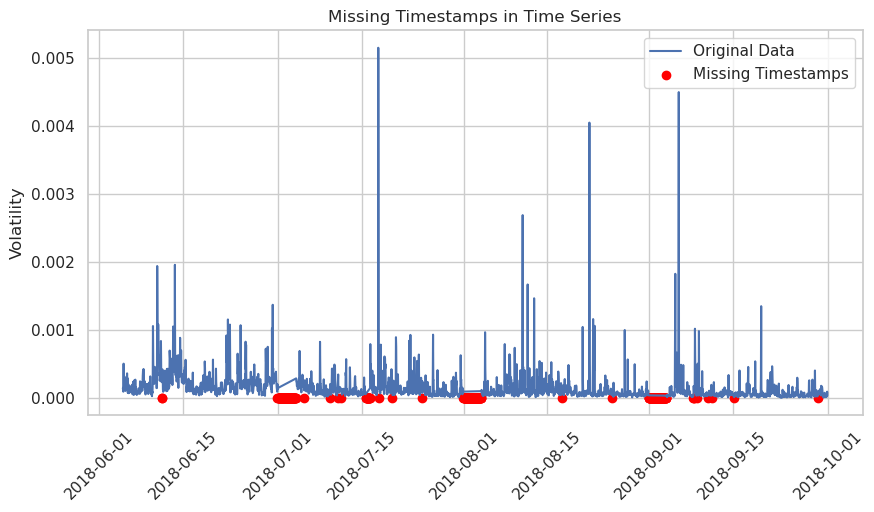

In [96]:
# plot the missing timestamps
plt.figure(figsize=(10, 5))
plt.plot(full_vola_ser.index, full_vola_ser.values, label="Original Data")
plt.scatter(
    missing_timestamps,
    [0] * len(missing_timestamps),
    color="red",
    label="Missing Timestamps",
)
plt.title("Missing Timestamps in Time Series")
# plt.xlabel('t')
plt.ylabel("Volatility")
plt.xticks(rotation=45)
plt.legend()
plt.show()